# import libraries

In [1]:
import sys
import os
os.chdir('E:\ISB work stuff\Post-Doc_BaligaLab_GBMSYGNALProject')
import miner as miner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import time
import imp
imp.reload(miner)
import miner_py3_kk as miner3

# Create directories to save output file

In [2]:
# Path to the miner directory
input_path = os.getcwd()

# create name for results folder where output files will be saved
resultsFolder = "results_miner3_gbm_MicroarrayRNA_survival_08252020"

# name of the folder containing the miner network
#networkFolder = "miner_network_results"
networkFolder = "results_minCorrelation_0o2_50_allFiles_gbm_MicroarrayRNA_survival_08252020"

# create results directory
resultsDirectory = os.path.join(os.getcwd(),resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

expressionData=pd.read_csv("GbmMicroRNAMergedWithIDsZScored.csv",header=0,index_col=0,sep=",")
#expressionData=pd.read_csv("Rembrandt_MinerInputFiltered.csv",header=0,index_col=0,sep=",")
#expressionData=pd.read_csv("GSE7696_MinerInputFiltered.csv",header=0,index_col=0,sep=",")
#expressionData=pd.read_csv("French_MinerInputFiltered.csv",header=0,index_col=0,sep=",")



# Load primary data

In [3]:
# Load mutations
common_mutations1 = pd.read_csv(os.path.join(input_path,'NonSilentPathwayMutationsGbmRNAAndMicroarray07242020.csv'),index_col=0,header=0)
common_mutations2 = pd.read_csv(os.path.join(input_path,'SignificantSomaticMutationsGbmRNAAndMicroarray07242020.csv'),index_col=0,header=0)
common_mutations3 = pd.read_csv(os.path.join(input_path,'mutations.GBM.TCGA.2019.05.01.csv'),index_col=0,header=0)
common_patients_mutations_translocations = list(set(common_mutations3.columns)&set(common_mutations2.columns)&set(common_mutations1.columns))
#common_patients_mutations_translocations = list(set(common_mutations3.columns)&set(common_patients_mutations_translocations.columns))
mutation_matrix = pd.concat([common_mutations1.loc[:,common_patients_mutations_translocations],common_mutations2.loc[:,common_patients_mutations_translocations],common_mutations3.loc[:,common_patients_mutations_translocations]],axis=0)


#If previous results exist, use miner.read_json to load them
#revisedClusters = miner.read_json(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowess.07.20.2020\\coexpressionDictionary.json"))
#coexpressionModules = miner.read_json(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowess.07.20.2020\\coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\regulons.json"))
regulonDfMicroGbmLatest = pd.read_csv("regulonDfGbmMicroRNASigCoxAndStatSig.csv", header = 0)
regulonDfMicroGbmLatest = list(regulonDfMicroGbmLatest['Regulon_ID'].drop_duplicates())
regulonDfMicroGbmLatest = [str(i) for i in regulonDfMicroGbmLatest]
regulonModules = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)
#mechanisticOutput = miner.read_json(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowess.07.20.2020\\mechanisticOutput.json"))
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\overExpressedMembersmiRNAAndTFRegulonsSig.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\underExpressedMembersmiRNAAndTFRegulonsSig.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\eigengenesmiRNAAndTFSig.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

# Load network

In [4]:
# Load Causal Mechanistic Network
filtered_causal_results = pd.read_csv(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\filteredCausalResults.csv"),index_col=0,header=0)
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,'GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\transcriptional_programsmiRNAAndSig.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,'GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\transcriptional_statesmiRNAAndTFSig.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list[:]
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

# Load primary survival data

In [5]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,"TCGA_Survival_Gbm.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
#print(survivalDfMMRF)
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)
#guanSurvivalDfMMRF.to_csv("guanSurvivalDf_TCGA_GBM.csv")

# Program activity heat map

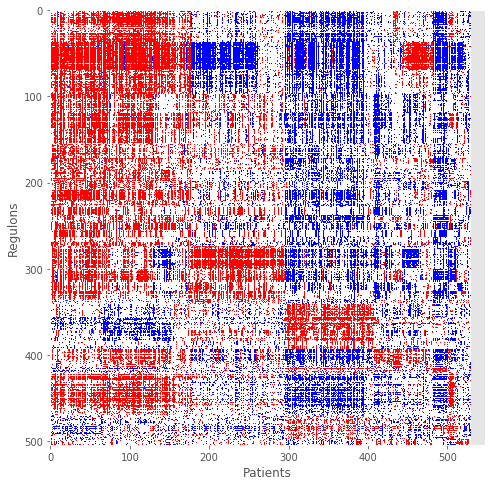

In [6]:
# Regulon activity heatmap
mtrx = diff_matrix_MMRF.loc[np.hstack(program_list),np.hstack(states_list)]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
plt.ylabel('Regulons')
plt.xlabel('Patients')
plt.savefig(os.path.join(resultsDirectory,"program_activity_heatmapSig.pdf"),bbox_inches="tight")

# Survival analysis of regulons

In [7]:
#regulonDfMicroGbm = pd.read_csv("regulonDfGbmMicroFrench.csv", header = 0)
#regulonDfMicroGbmlist = list(regulonDfMicroGbm['Regulon_ID'].drop_duplicates())
#regulonDfMicroGbmlist = [str(i) for i in regulonDfMicroGbmlist]
#regulonDfMicroGbm["Regulon_ID"] = regulonDfMicroGbm["Regulon_ID"].astype(str)
#regulonModules = {}
#for i in regulonDfMicroGbmlist:
#    regulonModules[i]= list(regulonDfMicroGbm[regulonDfMicroGbm['Regulon_ID']==i]['Gene'])

# Cox proportional hazards regression of regulons
t1 = time.time()

cox_regulons_output = miner.parallelMedianSurvivalAnalysis(regulonModules,expressionData,guanSurvivalDfMMRF,numCores=5)
cox_regulons_output = cox_regulons_output.iloc[np.argsort(np.array(cox_regulons_output.index).astype(int))]
cox_regulons_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsRegulonsmiRNAAndTFSig.csv'))
cox_regulons_output.sort_values(by="HR",ascending=False,inplace=True)

print("\nHigh-risk regulons:")
print(cox_regulons_output.iloc[0:5,:])
print("\nLow-risk regulons")
print(cox_regulons_output.iloc[-5:,:])

t2 = time.time()
print("Completed regulon risk analysis in {:.2f} minutes".format((t2-t1)/60.))



High-risk regulons:
            HR       p-value
1518  5.014802  5.308803e-07
3123  4.567590  4.933645e-06
2604  4.452387  8.492082e-06
66    4.176004  2.966745e-05
116   4.162867  3.142767e-05

Low-risk regulons
            HR   p-value
1519 -3.855115  0.000116
1502 -3.877505  0.000106
195  -3.881185  0.000104
3082 -3.937179  0.000082
1545 -4.001801  0.000063
Completed regulon risk analysis in 0.82 minutes


0.0
1940
1947
3559
0
343
810
811
2910
1545
719
716
1398
712
710
3333
1495
1497
1706
1707
1709
1067
295
292
293
290
195
1124
193
192
2825
2827
2821
2822
2823
2986
3021
2388
528
1404
449
448
2444
443
442
441
440
447
1239
445
1332
108
109
102
100
101
107
104
3153
39
38
1540
32
1840
37
35
34
1534
2168
438
439
436
434
432
2484
2839
337
333
2528
3299
3125
3458
3675
6
99
98
90
3206
3201
1628
1103
743
555
557
3635
553
238
239
2946
2460
236
231
1199
1054
714
1173
1170
1178
1889
3703
3707
2043
3118
3117
3116
3115
943
2085
1571
1570
1576
1575
1574
1304
1307
2717
1302
2651
2597
494
3597
3418
493
24
26
27
1834
23
1838
1839
28
406
405
1372
402
401
2158
2159
409
408
3242
2593
378
828
704
705
706
700
703
1483
1482
391
390
1486
1485
394
81
3303
84
796
795
794
792
790
2302
799
1658
1652
1653
1655
3667
2416
2284
245
244
247
241
243
242
2837
2836
2523
2830
3018
3019
1432
1433
1438
1662
519
513
515
623
3592
2596
1224
627
626
625
624
450
629
628
454
457
171
2053
2052
1502
1503
654
655
652
653
3080
3082
2627

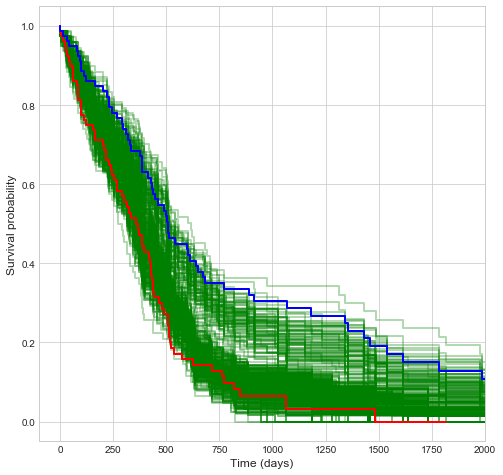

In [8]:
import warnings
warnings.filterwarnings("ignore")

# Cox proportional hazards regression of regulons
t1 = time.time()

t2 = time.time()
print(t2-t1)

# Kaplan-Meier plot of all programs (median expression)
srv = guanSurvivalDfMMRF.copy()
keys = list(regulonModules.keys())

plt.figure(figsize=(8,8))
plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)
for key in keys:
    print(key)
    cluster = np.array(expressionData.loc[regulonModules[key],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    membership_df = pd.DataFrame(median_)
    membership_df.index = expressionData.columns
    membership_df.columns = [key]

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

    groups_temp = list(membership_df.index[np.where(membership_df[key]==1)[0]])
    if len(groups_temp) != 0:
        groups = [membership_df.index[np.where(membership_df[key]==1)[0]]]
        labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
        miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                     filename=None,lw=2,color="gray",alpha=0.3)  
key_min = cox_regulons_output.index[0]
key_max = cox_regulons_output.index[-1]

cluster = np.array(expressionData.loc[regulonModules[key_min],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_min]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_min]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="red",alpha=1)  

    
cluster = np.array(expressionData.loc[regulonModules[key_max],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_max]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_max]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="blue",alpha=1) 
plt.ylabel('Survival probability')
plt.xlabel('Time (days)')
plt.savefig(os.path.join(resultsDirectory,"kmplots_regulonsSig.pdf"),bbox_inches="tight")



0.65413900386639
                1518
TCGA-19-4065     0.0
TCGA-19-4065.1   0.0
TCGA-06-0211.1   0.0
TCGA-06-AABW     0.0
TCGA-02-0055     0.0
...              ...
TCGA-28-1745     0.0
TCGA-28-1749     1.0
TCGA-06-0241     1.0
TCGA-06-0240     0.0
TCGA-19-1388     0.0

[548 rows x 1 columns]
[Index(['TCGA-27-2526', 'TCGA-27-2524', 'TCGA-32-2632', 'TCGA-06-0174',
       'TCGA-06-5418', 'TCGA-06-0747', 'TCGA-41-2571', 'TCGA-06-0750',
       'TCGA-06-0745', 'TCGA-12-3652', 'TCGA-12-3653', 'TCGA-12-3650',
       'TCGA-06-0686', 'TCGA-06-5408', 'TCGA-19-2624', 'TCGA-32-1970',
       'TCGA-26-5135', 'TCGA-26-5132', 'TCGA-15-0742', 'TCGA-12-5299',
       'TCGA-12-0618', 'TCGA-76-4927', 'TCGA-19-1390', 'TCGA-27-1837',
       'TCGA-28-5218', 'TCGA-19-2619', 'TCGA-06-0644', 'TCGA-27-2523',
       'TCGA-81-5910', 'TCGA-02-0321', 'TCGA-19-4068', 'TCGA-12-0819',
       'TCGA-19-5947', 'TCGA-19-2621', 'TCGA-12-0829', 'TCGA-12-0826',
       'TCGA-06-0650', 'TCGA-06-0876', 'TCGA-06-0875', 'TCGA-27-252

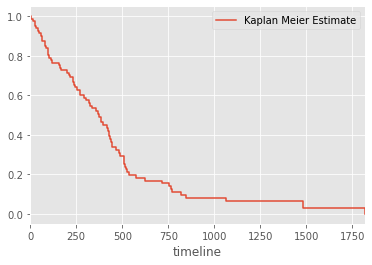

In [30]:
key_min = cox_regulons_output.index[0]
key_max = cox_regulons_output.index[-1]

cluster = np.array(expressionData.loc[regulonModules[key_min],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
print(threshold)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_min]
print(membership_df)

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_min]==1)[0]]]
print(groups)
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter() 
srv = guanSurvivalDfMMRF.copy()
patients = list(set(srv.index)&set(groups[0]))
kmDf = miner.kmAnalysis(survivalDf=srv.loc[patients,["duration","observed"]],durationCol="duration",statusCol="observed")
subset = kmDf[kmDf.loc[:,"observed"]==1]
duration = np.concatenate([np.array([0]),np.array(subset.loc[:,"duration"])])
print(duration)
srv1 = srv.loc[patients,["duration"]]
srv2 = srv.loc[patients,["observed"]]
## Fit the data into the model
kmf.fit(list(srv1['duration']), event_observed = list(srv2['observed']),label='Kaplan Meier Estimate')

## Create an estimate
kmf.plot(ci_show=False)
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
print(labels)
srv = guanSurvivalDfMMRF.copy()


# Survival analysis of transcriptional programs


High-risk programs:
          HR   p-value
5   4.189554  0.000028
22  3.566297  0.000362
16  3.387871  0.000704
10  3.352876  0.000800
3   3.346762  0.000818

Low-risk programs
          HR   p-value
24 -2.643997  0.008193
25 -2.762812  0.005731
28 -3.048242  0.002302
34 -3.288671  0.001007
29 -3.896997  0.000097
16.5839998722


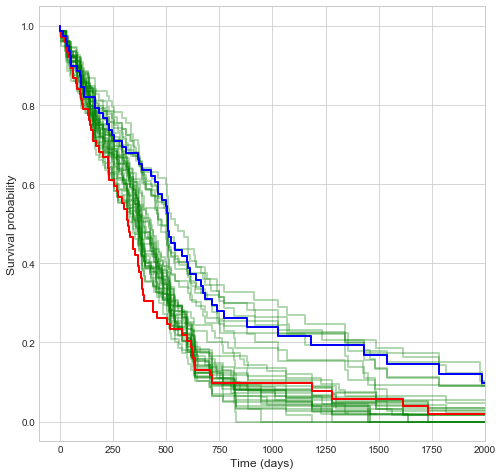

In [9]:
# Create dictionary of program genes
# make dictionary of genes by program
#regulonModules = {str(k):str(v) for k,v in regulonModules.items()}

pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes

# Cox proportional hazards regression of transcriptional programs
t1 = time.time()

cox_programs_output = miner.parallelMedianSurvivalAnalysis(pr_genes,expressionData,guanSurvivalDfMMRF,numCores=5)
cox_programs_output = cox_programs_output.iloc[np.argsort(np.array(cox_programs_output.index).astype(int))]
cox_programs_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsProgramsSig.csv'))
cox_programs_output.sort_values(by="HR",ascending=False,inplace=True)

print("\nHigh-risk programs:")
print(cox_programs_output.iloc[0:5,:])
print("\nLow-risk programs")
print(cox_programs_output.iloc[-5:,:])

t2 = time.time()
print(t2-t1)

# Kaplan-Meier plot of all programs (median expression)
srv = guanSurvivalDfMMRF.copy()
keys = list(pr_genes.keys())

plt.figure(figsize=(8,8))
plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)
for key in keys:
    cluster = np.array(expressionData.loc[pr_genes[key],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    membership_df = pd.DataFrame(median_)
    membership_df.index = expressionData.columns
    membership_df.columns = [key]

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

    groups = [membership_df.index[np.where(membership_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="gray",alpha=0.3)  


key_min = cox_programs_output.index[0]
key_max = cox_programs_output.index[-1]

cluster = np.array(expressionData.loc[pr_genes[key_min],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_min]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_min]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="red",alpha=1)  

    
cluster = np.array(expressionData.loc[pr_genes[key_max],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_max]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_max]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="blue",alpha=1) 
plt.ylabel('Survival probability')
plt.xlabel('Time (days)')
plt.savefig(os.path.join(resultsDirectory,"kmplots_programsSig.pdf"),bbox_inches="tight")

# Survival analysis of transcriptional states

TCGA_ID
TCGA-41-4097       6
TCGA-76-6193      82
TCGA-06-2562     382
TCGA-16-1055     313
TCGA-06-0878     218
TCGA-06-0149     262
TCGA-28-1751     232
TCGA-06-1802     466
TCGA-28-1753      37
TCGA-32-1977       3
TCGA-06-0210     225
TCGA-08-0356     946
TCGA-27-1830     154
TCGA-06-0143     357
TCGA-06-0140       6
TCGA-02-0075     634
TCGA-26-1439     422
TCGA-26-1438     305
TCGA-06-0124     620
TCGA-06-0169     100
TCGA-76-6282     519
TCGA-06-0122     187
TCGA-02-0079     829
TCGA-14-0781      29
TCGA-08-0521     146
TCGA-08-0525     486
TCGA-16-1045     883
TCGA-14-0789     342
TCGA-02-0085    1561
TCGA-14-1034     485
                ... 
TCGA-12-0772    1638
TCGA-06-0394     329
TCGA-14-1452     216
TCGA-06-0190     317
TCGA-06-0192    1185
TCGA-08-0346     256
TCGA-08-0347     782
TCGA-08-0509     382
TCGA-12-1094     372
TCGA-12-1095     482
TCGA-08-0360     468
TCGA-12-0654     231
TCGA-06-0155     318
TCGA-12-0619    1062
TCGA-02-0064     600
TCGA-41-3393     135
TCGA-

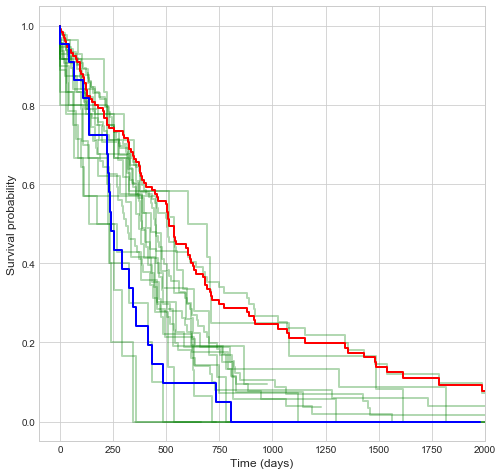

In [53]:
import imp
import miner as miner
imp.reload(miner)
# Kaplan-Meier plot of all programs (median expression)
plt.figure(figsize=(8,8))
plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)

srv = guanSurvivalDfMMRF.copy()
for key in range(len(states_list)):

    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[states_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="gray",alpha=0.3)  


# highlight_list = [
#                  np.hstack([states_list[4],states_list[5],states_list[16],states_list[23]])]

highlight_list = [
                 np.hstack([states_list[13], states_list[3], states_list[6]])]

for key in range(len(highlight_list)):
    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[highlight_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="red",alpha=1)  
    
# Combine high-risk states
# highlight_list = [
#                  np.hstack([states_list[10],states_list[14],states_list[21]])]

highlight_list = [
                 np.hstack([states_list[15], states_list[14], states_list[12]])]

for key in range(len(highlight_list)):
    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[highlight_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="blue",alpha=1)  
plt.ylabel('Survival probability')
plt.xlabel('Time (days)')    
plt.savefig(os.path.join(resultsDirectory,"kmplots_statesSig.pdf"),bbox_inches="tight")

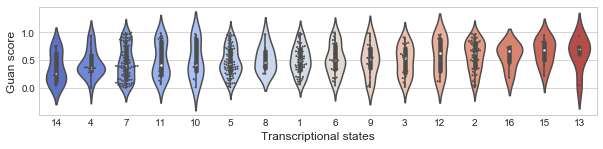

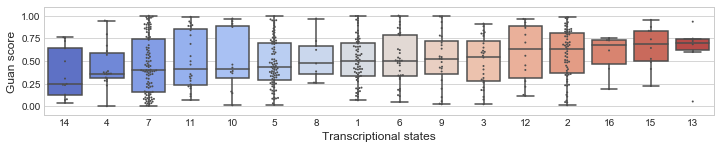

In [10]:
survival_patients = list(guanSurvivalDfMMRF.index)
#t414_patients = translocations.columns[
#    np.where(translocations.loc["RNASeq_WHSC1_Call",:]==1)[0]
#]
#t1114_patients = translocations.columns[
#    np.where(translocations.loc["RNASeq_CCND1_Call",:]==1)[0]
#]

min_patients = 5
ranks = []
boxplot_data = []
boxplot_names = []
boxplot_samples = []
boxplot_labels = []
percent_t414 = []
percent_t1114 = []
for key in range(len(states_list)):
    state = states_list[key]
    overlap_patients = list(set(survival_patients)&set(state))
    if len(overlap_patients) < min_patients:
        continue
    guan_data = list(guanSurvivalDfMMRF.loc[overlap_patients,"GuanScore"])
    boxplot_samples.append(overlap_patients)
    boxplot_data.append(guan_data)
    boxplot_names.append([1+key for i in range(len(overlap_patients))])
    risk_score = np.median(guan_data)
    ranks.append(risk_score)
    
    #t414_overlap = len(set(state)&set(t414_patients))
    #t1114_overlap = len(set(state)&set(t1114_patients))
    #percent_t414_ = float(t414_overlap)/len(state)
    #percent_t1114_ = float(t1114_overlap)/len(state)
    #percent_t414.append(percent_t414_)
    #percent_t1114.append(percent_t1114_)
         

labels = np.hstack(np.array(boxplot_names)[np.argsort(ranks)])
labels_df = pd.DataFrame(labels)
labels_df.index = np.hstack(np.array(boxplot_samples)[np.argsort(ranks)])
labels_df.columns = ["label"]
plot_data = pd.concat([guanSurvivalDfMMRF.loc[labels_df.index,"GuanScore"],labels_df],axis=1)


rank_order = np.array(list(set(np.hstack(boxplot_names))))[np.argsort(ranks)]
#ranked_t414 = np.array(percent_t414)[np.argsort(ranks)]
#ranked_t1114 = np.array(percent_t1114)[np.argsort(ranks)]

f, ax = plt.subplots(figsize=(10, 2))

# Plot the orbital period with horizontal boxes
sns.violinplot(x="label", y="GuanScore", data=plot_data,fliersize=0,
            palette="coolwarm",order=rank_order)

# Add in points to show each observation
sns.swarmplot(x="label", y="GuanScore", data=plot_data,
              size=2, color=".3", linewidth=0,order=rank_order)

# Tweak the visual presentation
ax.set(ylabel="Guan score")
ax.set(xlabel="Transcriptional states")

# Save figure
plt.savefig(os.path.join(resultsDirectory,"violin_states_riskSigmiRNAAndTF.pdf"),bbox_inches="tight")

f, ax = plt.subplots(figsize=(12, 2))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="label", y="GuanScore", data=plot_data,fliersize=0,
            palette="coolwarm",order=rank_order)

# Add in points to show each observation
sns.swarmplot(x="label", y="GuanScore", data=plot_data,
              size=2, color=".3", linewidth=0,order=rank_order)

# Tweak the visual presentation
ax.set(ylabel="Guan score")
ax.set(xlabel="Transcriptional states")
ax.set(ylim=(-0.1,1.1))

# Save figure
plt.savefig(os.path.join(resultsDirectory,"boxplot_states_riskSigmiRNAAndTF.pdf"),bbox_inches="tight")


              duration  observed  kmEstimate  GuanScore
TCGA_ID                                                
TCGA-06-1086       208         1    0.759879   0.761354
TCGA-32-2616       224         1    0.747477   0.748929
TCGA-02-0058       254         1    0.716073   0.719405
TCGA-02-0038       326         1    0.638204   0.639443
TCGA-02-0057       604         1    0.304308   0.304899
TCGA-02-0083       691         1    0.244579   0.246025
TCGA-02-0007       705         1    0.235172   0.236600
TCGA-28-5214       713         1    0.232821   0.233273
TCGA-02-0010      1077         1    0.127256   0.127503
TCGA-02-0116      1489         1    0.076586   0.076734
TCGA-02-0024      1615         1    0.067749   0.067880
TCGA-02-0021      2362         1    0.038629   0.038704


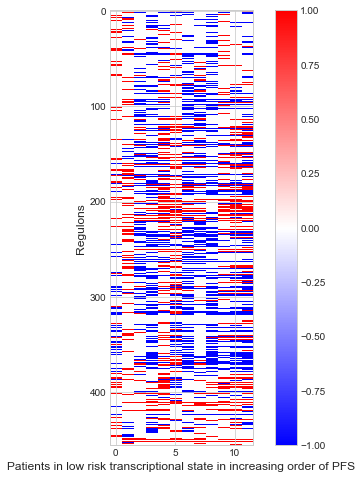

In [54]:

cox_regulons_output_0o05 = cox_regulons_output.loc[cox_regulons_output['p-value']<=0.05]
cox_regulons_output_0o05list = list(cox_regulons_output_0o05.index.values)
cox_regulons_output_0o05list = [str(x) for x in cox_regulons_output_0o05list]
cox_regulons_output_0o05list
#Heat map for regulonss and patients ordered by progression free survival days
state_17Sorted = guanSurvivalDfMMRF[guanSurvivalDfMMRF.index.isin(states_list[13])]
state_17Sorted = state_17Sorted.sort_values(by=['duration'])
state_17Sorted = state_17Sorted[state_17Sorted.observed != 0]
state_17SortedList = state_17Sorted.index.values
print(state_17Sorted)
# Regulon activity heatmap
plt.figure(figsize=(8,8))
plt.xlabel('Patients in low risk transcriptional state in increasing order of PFS')
plt.ylabel('Regulons')
im = plt.imshow(diff_matrix_MMRF.loc[np.hstack(cox_regulons_output_0o05list),np.hstack(state_17SortedList)],
          cmap="bwr",vmin=-1,vmax=1,aspect=0.08)
lowRiskActivityDf = diff_matrix_MMRF.loc[np.hstack(cox_regulons_output_0o05list),np.hstack(state_17SortedList)]

plt.colorbar(im)
#plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"regulon_activity_heatmap_lowrisk_WithSigCoxRatioSigRegulons.pdf"),bbox_inches="tight")
diff_matrix_MMRF.loc[np.hstack(cox_regulons_output_0o05list),np.hstack(state_17SortedList)].to_csv("TS_Low_RegulonAcivity_WithSigCoxRatioSigRegulons.csv")

              duration  observed  kmEstimate  GuanScore
TCGA_ID                                                
TCGA-14-0813        41         1    0.951057   0.952904
TCGA-06-0142        67         1    0.931374   0.933183
TCGA-19-1392       111         1    0.870190   0.874792
TCGA-06-0173       136         1    0.830473   0.832085
TCGA-76-4926       138         1    0.826490   0.829065
TCGA-06-0195       225         1    0.743313   0.745727
TCGA-12-1090       231         1    0.734961   0.738330
TCGA-06-5411       254         1    0.716073   0.719405
TCGA-41-2575       290         1    0.681831   0.683155
TCGA-12-0821       323         1    0.640389   0.642604
TCGA-06-0160       359         1    0.596622   0.597780
TCGA-06-1804       414         1    0.521769   0.522782
TCGA-19-0963       434         1    0.488614   0.489563
TCGA-02-0290       485         1    0.408189   0.410923
TCGA-06-0216       735         1    0.223414   0.223847
TCGA-02-0104      1977         1    0.051865   0

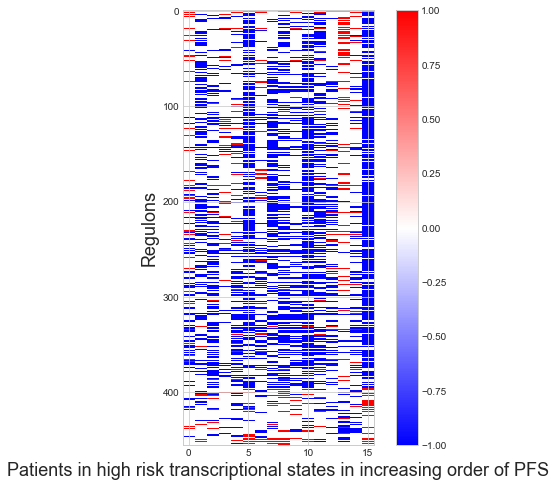

In [57]:
state_17Sorted = guanSurvivalDfMMRF[guanSurvivalDfMMRF.index.isin(states_list[14]+states_list[12])]
state_17Sorted = state_17Sorted.sort_values(by=['duration'])
state_17Sorted = state_17Sorted[state_17Sorted.observed != 0]
state_17SortedList = state_17Sorted.index.values
print(state_17Sorted)
# Regulon activity heatmap
plt.figure(figsize=(8,8))
plt.xlabel('Patients in high risk transcriptional states in increasing order of PFS', fontsize=18)
plt.ylabel('Regulons', fontsize=18)

im = plt.imshow(diff_matrix_MMRF.loc[np.hstack(cox_regulons_output_0o05list),np.hstack(state_17SortedList)],
          cmap="bwr",vmin=-1,vmax=1,aspect=0.08)
highRiskActivityDf = diff_matrix_MMRF.loc[np.hstack(cox_regulons_output_0o05list),np.hstack(state_17SortedList)]
plt.colorbar(im)
#plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"regulon_activity_heatmap_highrisk_WithSigCoxRatioSigRegulons.pdf"),bbox_inches="tight")
diff_matrix_MMRF.loc[np.hstack(cox_regulons_output_0o05list),np.hstack(state_17SortedList)].to_csv("TS_High_RegulonAcivity_WithSigCoxRatioSigRegulons.csv")

In [59]:
TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubType = TCGAPatientSubType[TCGAPatientSubType['Histological_type']== "untreated primary (de novo) gbm"]
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['Subtype']== "g_cimp"]
TCGAPatientSubTypeClass = set(list(TCGAPatientSubTypeSpecific['TCGA_ID']))
TS1 = TCGAPatientSubTypeClass.intersection(set(states_list[0]))
TS2 = TCGAPatientSubTypeClass.intersection(set(states_list[1]))
TS3 = TCGAPatientSubTypeClass.intersection(set(states_list[2]))
TS4 = TCGAPatientSubTypeClass.intersection(set(states_list[3]))
TS5 = TCGAPatientSubTypeClass.intersection(set(states_list[4]))
TS6 = TCGAPatientSubTypeClass.intersection(set(states_list[5]))
TS7 = TCGAPatientSubTypeClass.intersection(set(states_list[6]))
TS8 = TCGAPatientSubTypeClass.intersection(set(states_list[7]))
TS9 = TCGAPatientSubTypeClass.intersection(set(states_list[8]))
TS10 = TCGAPatientSubTypeClass.intersection(set(states_list[9]))
TS11 = TCGAPatientSubTypeClass.intersection(set(states_list[10]))
TS12 = TCGAPatientSubTypeClass.intersection(set(states_list[11]))
TS13 = TCGAPatientSubTypeClass.intersection(set(states_list[12]))
TS14 = TCGAPatientSubTypeClass.intersection(set(states_list[13]))
TS15 = TCGAPatientSubTypeClass.intersection(set(states_list[14]))
TS16 = TCGAPatientSubTypeClass.intersection(set(states_list[15]))
#TS17 = TCGAPatientSubTypeClass.intersection(set(states_list[16]))
#TS18 = TCGAPatientSubTypeClass.intersection(set(states_list[17]))
#TS19 = TCGAPatientSubTypeClass.intersection(set(states_list[18]))
#TS20 = TCGAPatientSubTypeClass.intersection(set(states_list[19]))
#TS21 = TCGAPatientSubTypeClass.intersection(set(states_list[20]))
#TS22 = TCGAPatientSubTypeClass.intersection(set(states_list[21]))

TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubType = TCGAPatientSubType[TCGAPatientSubType['Histological_type']== "untreated primary (de novo) gbm"]
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['Subtype']== "classical"]
TCGAPatientSubTypeClass = set(list(TCGAPatientSubTypeSpecific['TCGA_ID']))
TS1_1 = TCGAPatientSubTypeClass.intersection(set(states_list[0]))
TS2_1 = TCGAPatientSubTypeClass.intersection(set(states_list[1]))
TS3_1 = TCGAPatientSubTypeClass.intersection(set(states_list[2]))
TS4_1 = TCGAPatientSubTypeClass.intersection(set(states_list[3]))
TS5_1 = TCGAPatientSubTypeClass.intersection(set(states_list[4]))
TS6_1 = TCGAPatientSubTypeClass.intersection(set(states_list[5]))
TS7_1 = TCGAPatientSubTypeClass.intersection(set(states_list[6]))
TS8_1 = TCGAPatientSubTypeClass.intersection(set(states_list[7]))
TS9_1 = TCGAPatientSubTypeClass.intersection(set(states_list[8]))
TS10_1 = TCGAPatientSubTypeClass.intersection(set(states_list[9]))
TS11_1 = TCGAPatientSubTypeClass.intersection(set(states_list[10]))
TS12_1 = TCGAPatientSubTypeClass.intersection(set(states_list[11]))
TS13_1 = TCGAPatientSubTypeClass.intersection(set(states_list[12]))
TS14_1 = TCGAPatientSubTypeClass.intersection(set(states_list[13]))
TS15_1 = TCGAPatientSubTypeClass.intersection(set(states_list[14]))
TS16_1 = TCGAPatientSubTypeClass.intersection(set(states_list[15]))
#TS17_1 = TCGAPatientSubTypeClass.intersection(set(states_list[16]))
#TS18_1 = TCGAPatientSubTypeClass.intersection(set(states_list[17]))
#TS19_1 = TCGAPatientSubTypeClass.intersection(set(states_list[18]))
#TS20_1 = TCGAPatientSubTypeClass.intersection(set(states_list[19]))
#TS21_1 = TCGAPatientSubTypeClass.intersection(set(states_list[20]))
#TS22_1 = TCGAPatientSubTypeClass.intersection(set(states_list[21]))

TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubType = TCGAPatientSubType[TCGAPatientSubType['Histological_type']== "untreated primary (de novo) gbm"]
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['Subtype']== "proneural"]
TCGAPatientSubTypeClass = set(list(TCGAPatientSubTypeSpecific['TCGA_ID']))
TS1_2 = TCGAPatientSubTypeClass.intersection(set(states_list[0]))
TS2_2 = TCGAPatientSubTypeClass.intersection(set(states_list[1]))
TS3_2 = TCGAPatientSubTypeClass.intersection(set(states_list[2]))
TS4_2 = TCGAPatientSubTypeClass.intersection(set(states_list[3]))
TS5_2 = TCGAPatientSubTypeClass.intersection(set(states_list[4]))
TS6_2 = TCGAPatientSubTypeClass.intersection(set(states_list[5]))
TS7_2 = TCGAPatientSubTypeClass.intersection(set(states_list[6]))
TS8_2 = TCGAPatientSubTypeClass.intersection(set(states_list[7]))
TS9_2 = TCGAPatientSubTypeClass.intersection(set(states_list[8]))
TS10_2 = TCGAPatientSubTypeClass.intersection(set(states_list[9]))
TS11_2 = TCGAPatientSubTypeClass.intersection(set(states_list[10]))
TS12_2 = TCGAPatientSubTypeClass.intersection(set(states_list[11]))
TS13_2 = TCGAPatientSubTypeClass.intersection(set(states_list[12]))
TS14_2 = TCGAPatientSubTypeClass.intersection(set(states_list[13]))
TS15_2 = TCGAPatientSubTypeClass.intersection(set(states_list[14]))
TS16_2 = TCGAPatientSubTypeClass.intersection(set(states_list[15]))
#TS17_2 = TCGAPatientSubTypeClass.intersection(set(states_list[16]))
#TS18_2 = TCGAPatientSubTypeClass.intersection(set(states_list[17]))
#TS19_2 = TCGAPatientSubTypeClass.intersection(set(states_list[18]))
#TS20_2 = TCGAPatientSubTypeClass.intersection(set(states_list[19]))
#TS21_2 = TCGAPatientSubTypeClass.intersection(set(states_list[20]))
#TS22_2 = TCGAPatientSubTypeClass.intersection(set(states_list[21]))

TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubType = TCGAPatientSubType[TCGAPatientSubType['Histological_type']== "untreated primary (de novo) gbm"]
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['Subtype']== "neural"]
TCGAPatientSubTypeClass = set(list(TCGAPatientSubTypeSpecific['TCGA_ID']))
TS1_3 = TCGAPatientSubTypeClass.intersection(set(states_list[0]))
TS2_3 = TCGAPatientSubTypeClass.intersection(set(states_list[1]))
TS3_3 = TCGAPatientSubTypeClass.intersection(set(states_list[2]))
TS4_3 = TCGAPatientSubTypeClass.intersection(set(states_list[3]))
TS5_3 = TCGAPatientSubTypeClass.intersection(set(states_list[4]))
TS6_3 = TCGAPatientSubTypeClass.intersection(set(states_list[5]))
TS7_3 = TCGAPatientSubTypeClass.intersection(set(states_list[6]))
TS8_3 = TCGAPatientSubTypeClass.intersection(set(states_list[7]))
TS9_3 = TCGAPatientSubTypeClass.intersection(set(states_list[8]))
TS10_3 = TCGAPatientSubTypeClass.intersection(set(states_list[9]))
TS11_3 = TCGAPatientSubTypeClass.intersection(set(states_list[10]))
TS12_3 = TCGAPatientSubTypeClass.intersection(set(states_list[11]))
TS13_3 = TCGAPatientSubTypeClass.intersection(set(states_list[12]))
TS14_3 = TCGAPatientSubTypeClass.intersection(set(states_list[13]))
TS15_3 = TCGAPatientSubTypeClass.intersection(set(states_list[14]))
TS16_3 = TCGAPatientSubTypeClass.intersection(set(states_list[15]))
#TS17_3 = TCGAPatientSubTypeClass.intersection(set(states_list[16]))
#TS18_3 = TCGAPatientSubTypeClass.intersection(set(states_list[17]))
#TS19_3 = TCGAPatientSubTypeClass.intersection(set(states_list[18]))
#TS20_3 = TCGAPatientSubTypeClass.intersection(set(states_list[19]))
#TS21_3 = TCGAPatientSubTypeClass.intersection(set(states_list[20]))
#TS22_3 = TCGAPatientSubTypeClass.intersection(set(states_list[21]))

TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubType = TCGAPatientSubType[TCGAPatientSubType['Histological_type']== "untreated primary (de novo) gbm"]
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['Subtype']== "mesenchymal"]
TCGAPatientSubTypeClass = set(list(TCGAPatientSubTypeSpecific['TCGA_ID']))
TS1_4 = TCGAPatientSubTypeClass.intersection(set(states_list[0]))
TS2_4 = TCGAPatientSubTypeClass.intersection(set(states_list[1]))
TS3_4 = TCGAPatientSubTypeClass.intersection(set(states_list[2]))
TS4_4 = TCGAPatientSubTypeClass.intersection(set(states_list[3]))
TS5_4 = TCGAPatientSubTypeClass.intersection(set(states_list[4]))
TS6_4 = TCGAPatientSubTypeClass.intersection(set(states_list[5]))
TS7_4 = TCGAPatientSubTypeClass.intersection(set(states_list[6]))
TS8_4 = TCGAPatientSubTypeClass.intersection(set(states_list[7]))
TS9_4 = TCGAPatientSubTypeClass.intersection(set(states_list[8]))
TS10_4 = TCGAPatientSubTypeClass.intersection(set(states_list[9]))
TS11_4 = TCGAPatientSubTypeClass.intersection(set(states_list[10]))
TS12_4 = TCGAPatientSubTypeClass.intersection(set(states_list[11]))
TS13_4 = TCGAPatientSubTypeClass.intersection(set(states_list[12]))
TS14_4 = TCGAPatientSubTypeClass.intersection(set(states_list[13]))
TS15_4 = TCGAPatientSubTypeClass.intersection(set(states_list[14]))
TS16_4 = TCGAPatientSubTypeClass.intersection(set(states_list[15]))
#TS17_4 = TCGAPatientSubTypeClass.intersection(set(states_list[16]))
#TS18_4 = TCGAPatientSubTypeClass.intersection(set(states_list[17]))
#TS19_4 = TCGAPatientSubTypeClass.intersection(set(states_list[18]))
#TS20_4 = TCGAPatientSubTypeClass.intersection(set(states_list[19]))
#TS21_4 = TCGAPatientSubTypeClass.intersection(set(states_list[20]))
#TS22_4 = TCGAPatientSubTypeClass.intersection(set(states_list[21]))

print(len(TS14), len(TS4), len(TS7), len(TS11), len(TS10), len(TS5), len(TS8), len(TS1), len(TS6), len(TS9), len(TS3), len(TS12), len(TS2), len(TS16), len(TS15), len(TS13))

print(len(TS14_1), len(TS4_1), len(TS7_1), len(TS11_1), len(TS10_1), len(TS5_1), len(TS8_1), len(TS1_1), len(TS6_1), len(TS9_1), len(TS3_1), len(TS12_1), len(TS2_1), len(TS16_1), len(TS15_1), len(TS13_1))

print(len(TS14_2), len(TS4_2), len(TS7_2), len(TS11_2), len(TS10_2), len(TS5_2), len(TS8_2), len(TS1_2), len(TS6_2), len(TS9_2), len(TS3_2), len(TS12_2), len(TS2_2), len(TS16_2), len(TS15_2), len(TS13_2))

print(len(TS14_3), len(TS4_3), len(TS7_3), len(TS11_3), len(TS10_3), len(TS5_3), len(TS8_3), len(TS1_3), len(TS6_3), len(TS9_3), len(TS3_3), len(TS12_3), len(TS2_3), len(TS16_3), len(TS15_3), len(TS13_3))

print(len(TS14_4), len(TS4_4), len(TS7_4), len(TS11_4), len(TS10_4), len(TS5_4), len(TS8_4), len(TS1_4), len(TS6_4), len(TS9_4), len(TS3_4), len(TS12_4), len(TS2_4), len(TS16_4), len(TS15_4), len(TS13_4))


(0, 0, 29, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
(2, 5, 5, 0, 1, 71, 0, 15, 22, 2, 3, 2, 5, 1, 3, 0)
(0, 2, 58, 5, 0, 3, 7, 2, 2, 2, 2, 5, 0, 1, 3, 1)
(0, 3, 7, 10, 9, 8, 0, 2, 4, 16, 4, 5, 2, 2, 3, 2)
(4, 9, 1, 5, 0, 1, 2, 47, 4, 3, 18, 2, 51, 2, 1, 0)


In [60]:
TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubType = TCGAPatientSubType[TCGAPatientSubType['Histological_type']== "untreated primary (de novo) gbm"]
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['MGMT_Status']== "Methylated"]
TCGAPatientSubTypeClass = set(list(TCGAPatientSubTypeSpecific['TCGA_ID']))
TS1 = TCGAPatientSubTypeClass.intersection(set(states_list[0]))
TS2 = TCGAPatientSubTypeClass.intersection(set(states_list[1]))
TS3 = TCGAPatientSubTypeClass.intersection(set(states_list[2]))
TS4 = TCGAPatientSubTypeClass.intersection(set(states_list[3]))
TS5 = TCGAPatientSubTypeClass.intersection(set(states_list[4]))
TS6 = TCGAPatientSubTypeClass.intersection(set(states_list[5]))
TS7 = TCGAPatientSubTypeClass.intersection(set(states_list[6]))
TS8 = TCGAPatientSubTypeClass.intersection(set(states_list[7]))
TS9 = TCGAPatientSubTypeClass.intersection(set(states_list[8]))
TS10 = TCGAPatientSubTypeClass.intersection(set(states_list[9]))
TS11 = TCGAPatientSubTypeClass.intersection(set(states_list[10]))
TS12 = TCGAPatientSubTypeClass.intersection(set(states_list[11]))
TS13 = TCGAPatientSubTypeClass.intersection(set(states_list[12]))
TS14 = TCGAPatientSubTypeClass.intersection(set(states_list[13]))
TS15 = TCGAPatientSubTypeClass.intersection(set(states_list[14]))
TS16 = TCGAPatientSubTypeClass.intersection(set(states_list[15]))
#TS17 = TCGAPatientSubTypeClass.intersection(set(states_list[16]))
#TS18 = TCGAPatientSubTypeClass.intersection(set(states_list[17]))
#TS19 = TCGAPatientSubTypeClass.intersection(set(states_list[18]))
#TS20 = TCGAPatientSubTypeClass.intersection(set(states_list[19]))
#TS21 = TCGAPatientSubTypeClass.intersection(set(states_list[20]))
#TS22 = TCGAPatientSubTypeClass.intersection(set(states_list[21]))

TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubType = TCGAPatientSubType[TCGAPatientSubType['Histological_type']== "untreated primary (de novo) gbm"]
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['MGMT_Status']== "Unmethylated"]
TCGAPatientSubTypeClass = set(list(TCGAPatientSubTypeSpecific['TCGA_ID']))
TS1_1 = TCGAPatientSubTypeClass.intersection(set(states_list[0]))
TS2_1 = TCGAPatientSubTypeClass.intersection(set(states_list[1]))
TS3_1 = TCGAPatientSubTypeClass.intersection(set(states_list[2]))
TS4_1 = TCGAPatientSubTypeClass.intersection(set(states_list[3]))
TS5_1 = TCGAPatientSubTypeClass.intersection(set(states_list[4]))
TS6_1 = TCGAPatientSubTypeClass.intersection(set(states_list[5]))
TS7_1 = TCGAPatientSubTypeClass.intersection(set(states_list[6]))
TS8_1 = TCGAPatientSubTypeClass.intersection(set(states_list[7]))
TS9_1 = TCGAPatientSubTypeClass.intersection(set(states_list[8]))
TS10_1 = TCGAPatientSubTypeClass.intersection(set(states_list[9]))
TS11_1 = TCGAPatientSubTypeClass.intersection(set(states_list[10]))
TS12_1 = TCGAPatientSubTypeClass.intersection(set(states_list[11]))
TS13_1 = TCGAPatientSubTypeClass.intersection(set(states_list[12]))
TS14_1 = TCGAPatientSubTypeClass.intersection(set(states_list[13]))
TS15_1 = TCGAPatientSubTypeClass.intersection(set(states_list[14]))
TS16_1 = TCGAPatientSubTypeClass.intersection(set(states_list[15]))
#TS17_1 = TCGAPatientSubTypeClass.intersection(set(states_list[16]))
#TS18_1 = TCGAPatientSubTypeClass.intersection(set(states_list[17]))
#TS19_1 = TCGAPatientSubTypeClass.intersection(set(states_list[18]))
#TS20_1 = TCGAPatientSubTypeClass.intersection(set(states_list[19]))
#TS21_1 = TCGAPatientSubTypeClass.intersection(set(states_list[20]))
#TS22_1 = TCGAPatientSubTypeClass.intersection(set(states_list[21]))
print(len(TS14), len(TS4), len(TS7), len(TS11), len(TS10), len(TS5), len(TS8), len(TS1), len(TS6), len(TS9), len(TS3), len(TS12), len(TS2), len(TS16), len(TS15), len(TS13))

print(len(TS14_1), len(TS4_1), len(TS7_1), len(TS11_1), len(TS10_1), len(TS5_1), len(TS8_1), len(TS1_1), len(TS6_1), len(TS9_1), len(TS3_1), len(TS12_1), len(TS2_1), len(TS16_1), len(TS15_1), len(TS13_1))

#print(len(TS10)+len(TS11)+len(TS7)+len(TS17)+len(TS16)+len(TS9), len(TS6)+len(TS4)+len(TS2)+len(TS5)+len(TS3)+len(TS14)+len(TS13), len(TS8)+len(TS8)+len(TS15)+len(TS1)+len(TS20)+len(TS18)+len(TS19))

#print(len(TS10_1)+len(TS11_1)+len(TS7_1)+len(TS17_1)+len(TS16_1)+len(TS9_1), len(TS6_1)+len(TS4_1)+len(TS2_1)+len(TS5_1)+len(TS3_1)+len(TS14_1)+len(TS13_1), len(TS8_1)+len(TS8_1)+len(TS15_1)+len(TS1_1)+len(TS20_1)+len(TS18_1)+len(TS19_1))


(0, 2, 12, 2, 0, 6, 0, 6, 3, 3, 1, 1, 5, 0, 2, 1)
(2, 4, 22, 8, 1, 16, 2, 18, 5, 9, 12, 2, 22, 1, 0, 1)


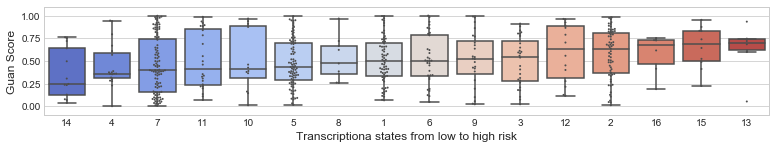

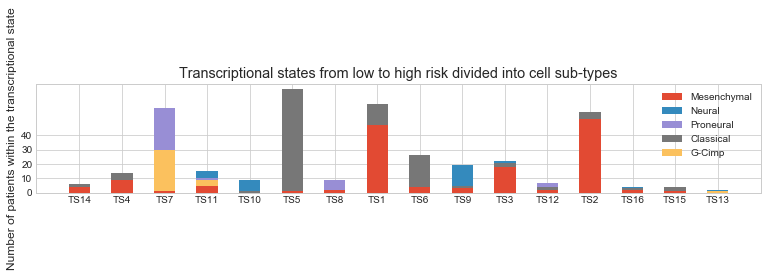

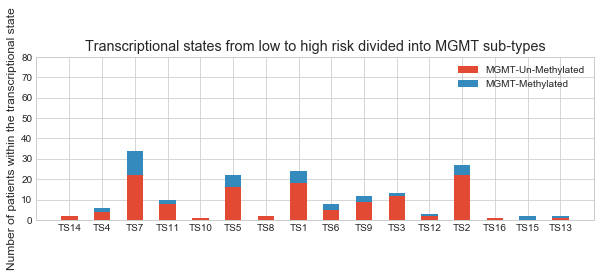

In [61]:
f, ax = plt.subplots(figsize=(13, 2))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="label", y="GuanScore", data=plot_data,fliersize=0,
            palette="coolwarm",order=rank_order)

# Add in points to show each observation
sns.swarmplot(x="label", y="GuanScore", data=plot_data,
              size=2, color=".3", linewidth=0,order=rank_order)

# Tweak the visual presentation
ax.set(ylabel="Guan Score")
ax.set(xlabel="Transcriptiona states from low to high risk")
ax.set(ylim=(-0.1,1.1))

# Save figure
plt.savefig(os.path.join(resultsDirectory,"boxplot_states_risk.pdf"),bbox_inches="tight")
import numpy as np
import matplotlib.pyplot as plt


N = 16

ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

g_cimp = (0, 0, 29, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
classical = (2, 5, 5, 0, 1, 71, 0, 15, 22, 2, 3, 2, 5, 1, 3, 0)
proneural = (0, 2, 58, 5, 0, 3, 7, 2, 2, 2, 2, 5, 0, 1, 3, 1)
neural = (0, 3, 7, 10, 9, 8, 0, 2, 4, 16, 4, 5, 2, 2, 3, 2)
mesenchymal = (4, 9, 1, 5, 0, 1, 2, 47, 4, 3, 18, 2, 51, 2, 1, 0)

plt.figure(figsize=(13, 2))
p0 = plt.bar(ind, mesenchymal, width)
p1 = plt.bar(ind, neural, width,
             bottom=mesenchymal)
p2 = plt.bar(ind, proneural, width,
             bottom=mesenchymal)
p3 = plt.bar(ind, classical, width,
             bottom=mesenchymal)
p4 = plt.bar(ind, g_cimp, width,
             bottom=mesenchymal)
plt.ylabel('Number of patients within the transcriptional state')
plt.title('Transcriptional states from low to high risk divided into cell sub-types')
plt.xticks(ind, ('TS14', 'TS4', 'TS7', 'TS11', 'TS10', 'TS5', 'TS8', 'TS1', 'TS6', 'TS9', 'TS3', 'TS12', 'TS2', 'TS16', 'TS15', 'TS13'))
plt.yticks(np.arange(0, 50, 10))
plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0]), ('Mesenchymal', 'Neural',"Proneural","Classical", "G-Cimp"))

plt.show()

N = 16


ind = np.arange(N)    # the x locations for the groups

width = 0.5  
MGMT = (0, 2, 12, 2, 0, 6, 0, 6, 3, 3, 1, 1, 5, 0, 2, 1)
NoMGMT = (2, 4, 22, 8, 1, 16, 2, 18, 5, 9, 12, 2, 22, 1, 0, 1)

plt.figure(figsize=(10, 3))
p1 = plt.bar(ind, NoMGMT, width)
p2 = plt.bar(ind, MGMT, width,
             bottom=NoMGMT)

plt.ylabel('Number of patients within the transcriptional state')
plt.title('Transcriptional states from low to high risk divided into MGMT sub-types')
plt.xticks(ind, ('TS14', 'TS4', 'TS7', 'TS11', 'TS10', 'TS5', 'TS8', 'TS1', 'TS6', 'TS9', 'TS3', 'TS12', 'TS2', 'TS16', 'TS15', 'TS13'))
plt.yticks(np.arange(0, 85, 10))
plt.legend((p1[0], p2[0]), ('MGMT-Un-Methylated', 'MGMT-Methylated'))

plt.show()



# Regulons that are active in high risk mesenchymal patients 

In [62]:
TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['Subtype']== "mesenchymal"]
TCGAPatientMesenSubType = list(set(list(TCGAPatientSubTypeSpecific['TCGA_ID'])))

TCGAPatientMesenSubTypeHighRisk = list(set(TCGAPatientMesenSubType).intersection(set(states_list[15]+states_list[14]+states_list[12])))
MesenchymalDfHighRisk = diff_matrix_MMRF[diff_matrix_MMRF.columns.intersection(TCGAPatientMesenSubTypeHighRisk)]
#MesenchymalDfHighRisk = MesenchymalDfHighRisk[(MesenchymalDfHighRisk != 0).any(axis=1)]
MesenchymalDfHighRisk.to_csv("GbmTCGARNAMicroMesenchymalHighRiskSigRegulons.csv")

TCGAPatientMesenSubTypeLowRisk = list(set(TCGAPatientMesenSubType).intersection(set(states_list[13]+states_list[3]+states_list[6])))
MesenchymalDfLowRisk = diff_matrix_MMRF[diff_matrix_MMRF.columns.intersection(TCGAPatientMesenSubTypeLowRisk)]
#MesenchymalDfLowRisk = MesenchymalDfLowRisk[(MesenchymalDfLowRisk == 0).any(axis=1)]
MesenchymalDfLowRisk.to_csv("GbmTCGARNAMicroMesenchymalLowRiskSigRegulons.csv")


# Regulons that are active in high risk non-MGMT patients 

In [63]:
TCGAPatientSubType = pd.read_csv("TCGA_Survival_Gbm.csv", header = 0)
TCGAPatientSubTypeSpecific = TCGAPatientSubType[TCGAPatientSubType['MGMT_Status']== "Unmethylated"]
TCGAPatientMGMTLowRisk = list(set(list(TCGAPatientSubTypeSpecific['TCGA_ID'])))
TCGAPatientMGMTLowRisk = list(set(TCGAPatientMGMTLowRisk).intersection(set(states_list[13]+states_list[3]+states_list[6])))
TCGAPatientMGMTLowRisk = diff_matrix_MMRF[diff_matrix_MMRF.columns.intersection(TCGAPatientMGMTLowRisk)]
#TCGAPatientMGMTLowRisk = TCGAPatientMGMTLowRisk[(TCGAPatientMGMTLowRisk != 0).any(axis=1)]
TCGAPatientMGMTLowRisk.to_csv("GbmTCGARNAMicroNonMGMTLowRiskSigRegulons.csv")

TCGAPatientMGMTHighRisk = list(set(list(TCGAPatientSubTypeSpecific['TCGA_ID'])))
TCGAPatientMGMTHighRisk = list(set(TCGAPatientMGMTHighRisk).intersection(set(states_list[15]+states_list[14]+states_list[12])))
TCGAPatientMGMTHighRisk = diff_matrix_MMRF[diff_matrix_MMRF.columns.intersection(TCGAPatientMGMTHighRisk)]
#TCGAPatientMGMTHighRisk = TCGAPatientMGMTHighRisk[(TCGAPatientMGMTHighRisk != 0).any(axis=1)]
TCGAPatientMGMTHighRisk.to_csv("GbmTCGARNAMicroNonMGMTHighRiskSigRegulons.csv")


# Examine P-Value distribution for sygnal strength

In [64]:
high_risk_ = guanSurvivalDfMMRF.index[0:183]
low_risk_ = guanSurvivalDfMMRF.index[183:]
pats = np.hstack([low_risk_,high_risk_])

# Mutations

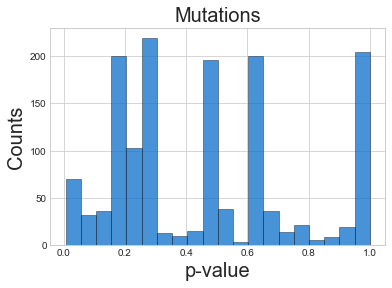

In [65]:
mut_pats = list(set(pats)&set(mutation_matrix.columns))
risk_status_df = pd.DataFrame(np.zeros(len(mut_pats)))
risk_status_df.index = mut_pats
risk_status_df.columns = ["high_risk"]
risk_status_df.loc[list(set(mut_pats)&set(high_risk_)),"high_risk"] = 1
risk_status_array = np.array(risk_status_df.iloc[:,0])
mut_status_array = np.array(mutation_matrix.loc[:,mut_pats])

mut_ps = miner.chiSquareTest(risk_status_array,mut_status_array)
_=plt.hist(mut_ps,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Counts",FontSize=20)
plt.xlabel("p-value",FontSize=20)
plt.title("Mutations",FontSize=20)
plt.savefig(os.path.join(resultsDirectory,"pvalue_distribution_mutations.pdf"),bbox_inches="tight")

# Genes

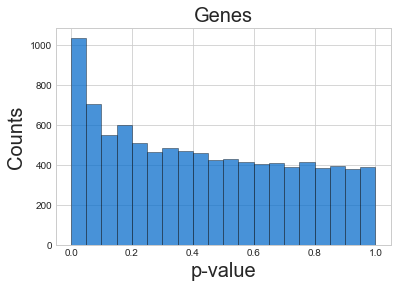

In [66]:
from scipy import stats
ts_exp, ps_exp = stats.ttest_ind(expressionData.loc[:,high_risk_].dropna(axis=1),expressionData.loc[:,low_risk_].dropna(axis=1),axis=1,equal_var=False)
_=plt.hist(ps_exp,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Counts",FontSize=20)
plt.xlabel("p-value",FontSize=20)
plt.title("Genes",FontSize=20)
plt.savefig(os.path.join(resultsDirectory,"pvalue_distribution_genes.pdf"),bbox_inches="tight")

# Regulons

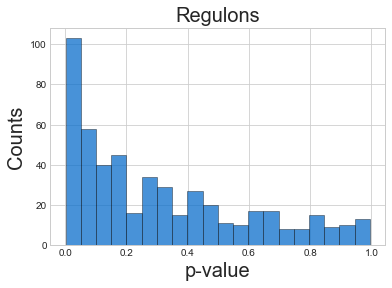

In [67]:
regulonModules = miner.read_json(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\regulons.json"))
regulonDfMicroGbmLatest = pd.read_csv("regulonDfGbmMicroRNASigCoxAndStatSig.csv", header = 0)
regulonDfMicroGbmLatest = list(regulonDfMicroGbmLatest['Regulon_ID'].drop_duplicates())
regulonDfMicroGbmLatest = [str(i) for i in regulonDfMicroGbmLatest]
regulonModules = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\overExpressedMembersmiRNAAndTFRegulonsSig.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\underExpressedMembersmiRNAAndTFRegulonsSig.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,"GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\eigengenesmiRNAAndTFSig.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix
regulon_pats = list(set(pats)&set(diff_matrix_MMRF.columns))
risk_status_df = pd.DataFrame(np.zeros(len(regulon_pats)))
risk_status_df.index = regulon_pats
risk_status_df.columns = ["high_risk"]
risk_status_df.loc[list(set(regulon_pats)&set(high_risk_)),"high_risk"] = 1
risk_status_array = np.array(risk_status_df.iloc[:,0])
regulon_status_array = np.array(diff_matrix_MMRF.loc[:,regulon_pats])

regulon_ps = miner.chiSquareTest(risk_status_array,regulon_status_array)
_=plt.hist(regulon_ps,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Counts",FontSize=20)
plt.xlabel("p-value",FontSize=20)
plt.title("Regulons",FontSize=20)
plt.savefig(os.path.join(resultsDirectory,"pvalue_distribution_regulons.pdf"),bbox_inches="tight")

# Programs

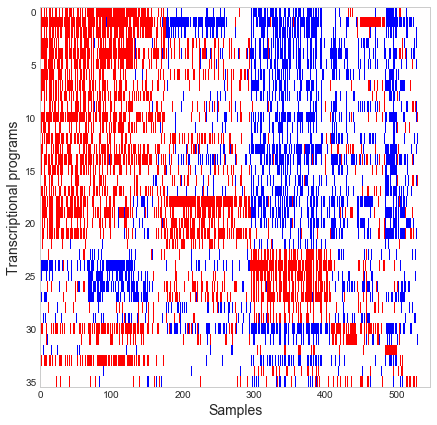

In [68]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,'GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\transcriptional_programsmiRNAAndSig.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,'GBM\\results\\MINER\\MINER_MicroLowessRNATMM.08.24.2020\\transcriptional_statesmiRNAAndTFSig.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list[:]
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix
statesDf = miner.reduceModules(df=diff_matrix_MMRF.loc[np.hstack(program_list),
                                                       np.hstack(states_list)],
                               programs=program_list,states=states_list,
                               stateThreshold=0.50,
                               saveFile=os.path.join(resultsDirectory,"transcriptional_programsSigRegulons.pdf"))

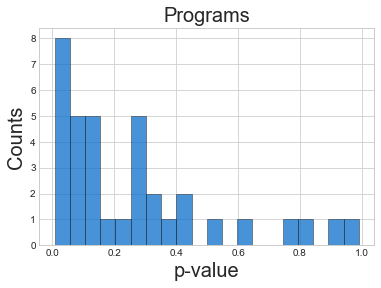

In [69]:
programs_pats = list(set(pats)&set(statesDf.columns))
risk_status_df = pd.DataFrame(np.zeros(len(programs_pats)))
risk_status_df.index = programs_pats
risk_status_df.columns = ["high_risk"]
risk_status_df.loc[list(set(programs_pats)&set(high_risk_)),"high_risk"] = 1
risk_status_array = np.array(risk_status_df.iloc[:,0])
programs_status_array = np.array(statesDf.loc[:,programs_pats])

programs_ps = miner.chiSquareTest(risk_status_array,programs_status_array)
_=plt.hist(programs_ps,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75)
plt.ylabel("Counts",FontSize=20)
plt.xlabel("p-value",FontSize=20)
plt.title("Programs",FontSize=20)
plt.savefig(os.path.join(resultsDirectory,"pvalue_distribution_programs.pdf"),bbox_inches="tight")

In [73]:
states_listarragnedbyGS = [states_list[13], states_list[3], states_list[6], states_list[10], states_list[9], states_list[4], states_list[7], states_list[0], states_list[5], states_list[8], states_list[2], states_list[11], states_list[1], states_list[15], states_list[14], states_list[12]]
stateslist = []
for i in range(len(states_listarragnedbyGS)):
    for j in states_listarragnedbyGS[i]:
        stateslist.append([i, j])
stateslistdf = pd.DataFrame(stateslist)
stateslistdf.columns = ['StatesOrderFromLowToHighMedianGuanScore','Patient_ID']
stateslistdf.to_csv("transcriptional_statesmiRNAAndTFSigGbmMinerOrderedByMedianGuanScore.csv")

# Regulon expression differences between independent datasets and training dataset that have cos HR of regulons significant in independent dataset but not in training data

In [35]:
expressionDataRembrandt = pd.read_csv("Rembrandt_MinerInputFiltered.csv",header=0,index_col=0,sep=",")
eigengenesRembrandt = miner.getEigengenes(regulonModules,expressionDataRembrandt,regulon_dict=None,saveFolder=None)
eigenScaleRembrandt = np.percentile(expressionDataRembrandt,95)/np.percentile(eigengenesRembrandt,95)
eigengenesRembrandt = eigenScaleRembrandt*eigengenesRembrandt
eigengenesRembrandt.index = np.array(eigengenesRembrandt.index).astype(str)
CoxHRRembrandt = pd.read_csv("CoxProportionalHazardsRegulonsRembrandt.csv",header=0,index_col=0,sep=",")

expressionDataFrench = pd.read_csv("French_MinerInputFiltered.csv",header=0,index_col=0,sep=",")
eigengenesFrench = miner.getEigengenes(regulonModules,expressionDataFrench,regulon_dict=None,saveFolder=None)
eigenScaleFrench = np.percentile(expressionDataFrench,95)/np.percentile(eigengenesFrench,95)
eigengenesFrench = eigenScaleFrench*eigengenesFrench
eigengenesFrench.index = np.array(eigengenesFrench.index).astype(str)
CoxHRFrench = pd.read_csv("CoxProportionalHazardsRegulonsFrench.csv",header=0,index_col=0,sep=",")

expressionDataGSE7696 = pd.read_csv("GSE7696_MinerInputFiltered.csv",header=0,index_col=0,sep=",")
eigengenesGSE7696 = miner.getEigengenes(regulonModules,expressionDataGSE7696,regulon_dict=None,saveFolder=None)
eigenScaleGSE7696 = np.percentile(expressionDataGSE7696,95)/np.percentile(eigengenesGSE7696,95)
eigengenesGSE7696 = eigenScaleGSE7696*eigengenesGSE7696
eigengenesGSE7696.index = np.array(eigengenesGSE7696.index).astype(str)
CoxHRGSE7696 = pd.read_csv("CoxProportionalHazardsRegulonsGSE7696.csv",header=0,index_col=0,sep=",")



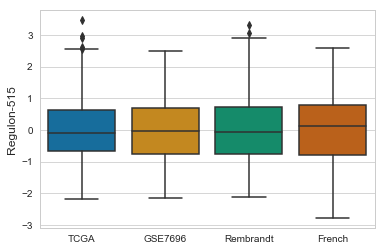

In [53]:
eigengenesGSE7696_515 = eigengenesGSE7696.iloc[515,:].T.to_frame()
eigengenesGSE7696_515['DataSource'] = 'GSE7696'
eigengenesGSE7696_515.columns = ['Regulon-515','DataSource']

eigengenesFrench_515 = eigengenesFrench.iloc[515,:].T.to_frame()
eigengenesFrench_515['DataSource'] = 'French'
eigengenesFrench_515.columns = ['Regulon-515','DataSource']

eigengenesRembrandt_515 = eigengenesRembrandt.iloc[515,:].T.to_frame()
eigengenesRembrandt_515['DataSource'] = 'Rembrandt'
eigengenesRembrandt_515.columns = ['Regulon-515','DataSource']

eigengenes_515 = eigengenes.loc['515',:].T.to_frame()
eigengenes_515['DataSource'] = 'TCGA'
eigengenes_515.columns = ['Regulon-515','DataSource']

eigengenesall = pd.concat([eigengenes_515,eigengenesGSE7696_515,eigengenesRembrandt_515,eigengenesFrench_515])
import seaborn as sns
sns.set_style("whitegrid") 
boxplot_3000 = sns.boxplot(y='Regulon-515', x='DataSource', 
                 data=eigengenesall, 
                 palette="colorblind").set(xlabel='', ylabel='Regulon-515')

# Guan score prediction as a function of program activity through ridge regression

# Only programs formed out of statistically signififcant and disease relevant (based on Cox HR P-Val <= 0.05) regulons

# Parameter optimization with all patients in TCGA survival data

High-risk MMRF: 68 samples
Low-risk MMRF: 67 samples
Optimization is 0.10% complete
Optimization is 10.10% complete
Optimization is 20.10% complete
Optimization is 30.10% complete
Optimization is 40.10% complete
Optimization is 50.10% complete
Optimization is 60.10% complete
Optimization is 70.10% complete
Optimization is 80.10% complete
Optimization is 90.10% complete


C:\Users\kkavy\miner_py3_matt.py:2726: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel("Regularization parameter",FontSize=20)
C:\Users\kkavy\miner_py3_matt.py:2727: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel("AUC",FontSize=20)
C:\Users\kkavy\miner_py3_matt.py:2728: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title("Parameter optimization",FontSize=20)


1e-100
0.5438966297770883


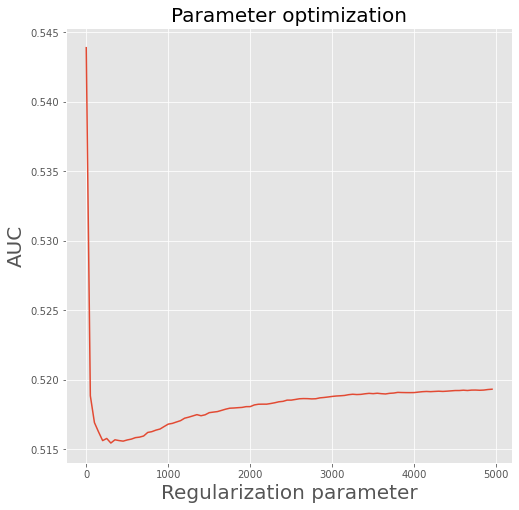

In [40]:
import miner_py3_matt as miner3
import imp
imp.reload(miner3)
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMmicroRNA.csv", header = 0, index_col = 0)
# =============================================================================
# Ridge regression to predict risk from regulon activity
# =============================================================================

# Training and test set risk cut-offs
train_cut_high = 0.50
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBMUnMethylated.csv", header = 0, index_col = 0)

high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])
print('High-risk MMRF: {:d} samples\nLow-risk MMRF: {:d} samples'.format(
        len(high_risk_),len(low_risk_)))
feature_matrix = dfr_programs
survival_matrix = guanSurvivalDf
savefile = os.path.join(resultsDirectory,"Ridge_optimizationUnMethylated_AllPatientsInTCGA_SurvivalGBM_ProgramsFromStatSigAndDiseaseRelevantRegulons.pdf")

alpha_opt_15, mean_result_15, sd_result_15, a_range_15 = miner3.optimize_ridge_model(
        feature_matrix,survival_matrix,n_iter=1000,train_cut_high = 0.50,
        train_cut_low = 0.50,max_range=5000,range_step=50,savefile=savefile)
print(alpha_opt_15)
print(np.max(mean_result_15))

# Paramter optimization with Top 20% and bottom 50% patients based on guan score on survival data

High-risk MMRF: 27 samples
Low-risk MMRF: 67 samples
Optimization is 0.10% complete
Optimization is 10.10% complete
Optimization is 20.10% complete
Optimization is 30.10% complete
Optimization is 40.10% complete
Optimization is 50.10% complete
Optimization is 60.10% complete
Optimization is 70.10% complete
Optimization is 80.10% complete
Optimization is 90.10% complete


C:\Users\kkavy\miner_py3_matt.py:2726: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel("Regularization parameter",FontSize=20)
C:\Users\kkavy\miner_py3_matt.py:2727: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel("AUC",FontSize=20)
C:\Users\kkavy\miner_py3_matt.py:2728: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title("Parameter optimization",FontSize=20)


0.0
0.6209062044026831


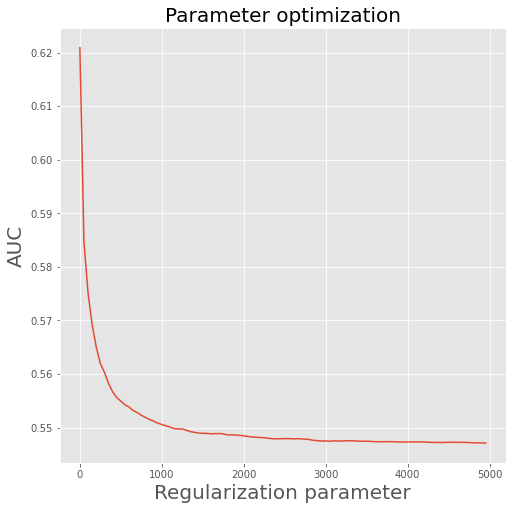

In [78]:
imp.reload(miner3)
# Training and test set risk cut-offs
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMmicroRNA.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBMUnMethylated.csv", header = 0, index_col = 0)

high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])
print('High-risk MMRF: {:d} samples\nLow-risk MMRF: {:d} samples'.format(
        len(high_risk_),len(low_risk_)))
feature_matrix = dfr_programs
survival_matrix = guanSurvivalDf
savefile = os.path.join(resultsDirectory,"Ridge_optimizationUnMethylated_Top20AndBottom50PercentInTCGA_SurvivalGBM_ProgramsFromStatSigAndDiseaseRelevantRegulons.pdf")

alpha_opt_16, mean_result_16, sd_result_16, a_range_16 = miner3.optimize_ridge_model(
        feature_matrix,survival_matrix,n_iter=1000,train_cut_high = 0.20,
        train_cut_low = 0.50,max_range=5000,range_step=50,savefile=savefile)
print(alpha_opt_16)
print(np.max(mean_result_16))

# All programs with all regulons

# Parameter optimization with all patients in TCGA survival data

High-risk MMRF: 258 samples
Low-risk MMRF: 258 samples
Optimization is 0.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.37281e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.24291e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.63421e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.72944e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.29508e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 10.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.79497e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.84364e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.87296e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.71653e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.01062e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 20.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.43621e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.40467e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.5752e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.64929e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.65361e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mod

Optimization is 30.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.40657e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.36695e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.75677e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.46686e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.38865e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 40.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.74883e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.68456e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.29665e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.31254e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.37334e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 50.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.91424e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.57272e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.73189e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3367e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.31218e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mod

Optimization is 60.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.48241e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.36288e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.22105e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.53654e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.67632e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 70.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.24326e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.23959e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.78985e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.59734e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.75467e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 80.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.32918e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.3808e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.74783e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.44423e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.53013e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mod

Optimization is 90.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.74651e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.50517e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.46432e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.50049e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.34113e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

500.0
0.5440799884408042


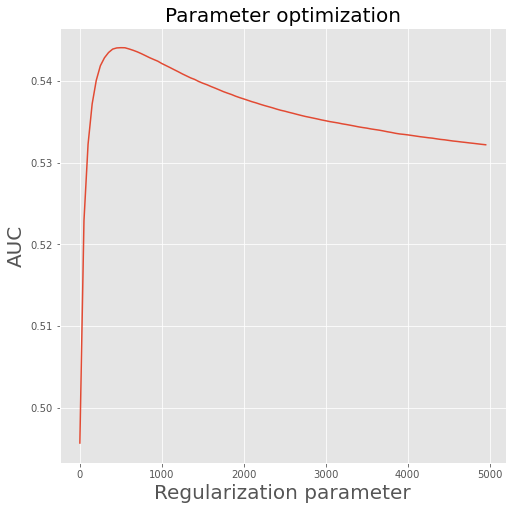

In [36]:
dfr_programs = pd.read_csv("program_activity_forAllRegulonsinAllProgramsGbmTCGA.csv", header = 0, index_col = 0)
# =============================================================================
# Ridge regression to predict risk from regulon activity
# =============================================================================

# Training and test set risk cut-offs
train_cut_high = 0.50
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)

high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])
print('High-risk MMRF: {:d} samples\nLow-risk MMRF: {:d} samples'.format(
        len(high_risk_),len(low_risk_)))
feature_matrix = dfr_programs
survival_matrix = guanSurvivalDf
savefile = os.path.join(resultsDirectory,"Ridge_optimizationOSBased_AllPatientsInTCGA_SurvivalGBM_AllProgramsWithAllRegulons.pdf")

alpha_opt_11, mean_result_11, sd_result_11, a_range_11 = miner3.optimize_ridge_model(
        feature_matrix,survival_matrix,n_iter=1000,train_cut_high = 0.50,
        train_cut_low = 0.50,max_range=5000,range_step=50,savefile=savefile)
print(alpha_opt_11)
print(np.max(mean_result_11))

# Paramter optimization with Top 20% and bottom 50% patients based on guan score on survival data

High-risk MMRF: 103 samples
Low-risk MMRF: 258 samples
Optimization is 0.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.37163e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.68718e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.94098e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.0369e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.93173e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mod

Optimization is 10.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.19141e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.10156e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.29118e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.35832e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.09089e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 20.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.04348e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.31062e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.13995e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.48128e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.89555e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 30.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.09489e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.28601e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.4253e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.08499e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.44439e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mod

Optimization is 40.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.79278e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.43708e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.94196e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.14408e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.49641e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 50.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.01103e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.27557e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.64689e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.20758e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.18735e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 60.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.34055e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.25216e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.79116e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.03439e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.02186e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 70.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.98937e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.19043e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.34398e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.60325e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.30556e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

Optimization is 80.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.91951e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.99549e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.1258e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.81204e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.22967e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mod

Optimization is 90.10% complete


C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.30242e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.12564e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.84979e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.32225e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.45629e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\linear_mo

100.0
0.5719203639818923


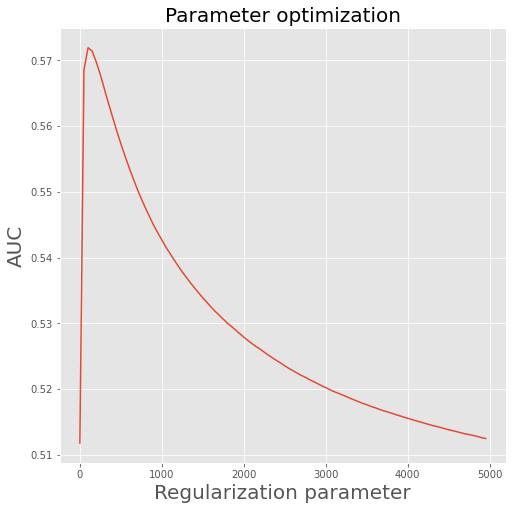

In [37]:
# Training and test set risk cut-offs
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)

high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])
print('High-risk MMRF: {:d} samples\nLow-risk MMRF: {:d} samples'.format(
        len(high_risk_),len(low_risk_)))
feature_matrix = dfr_programs
survival_matrix = guanSurvivalDf
savefile = os.path.join(resultsDirectory,"Ridge_optimizationOSBased_Top20AndBottom50PercentInTCGA_SurvivalGBM_AllProgramsWithAllRegulons.pdf")

alpha_opt_12, mean_result_12, sd_result_12, a_range_12 = miner3.optimize_ridge_model(
        feature_matrix,survival_matrix,n_iter=1000,train_cut_high = 0.20,
        train_cut_low = 0.50,max_range=5000,range_step=50,savefile=savefile)
print(alpha_opt_12)
print(np.max(mean_result_12))

# Model implementation, cross-validation and prediction

TCGA AUC: 0.71
[0.         0.         0.00968523 0.00968523 0.01210654 0.01210654
 0.01937046 0.01937046 0.02663438 0.02663438 0.02905569 0.02905569
 0.031477   0.031477   0.03389831 0.03389831 0.03631961 0.03631961
 0.03874092 0.03874092 0.04116223 0.04116223 0.05084746 0.05084746
 0.05326877 0.05326877 0.05569007 0.05569007 0.05811138 0.05811138
 0.0653753  0.0653753  0.08958838 0.08958838 0.09200969 0.09200969
 0.0968523  0.0968523  0.09927361 0.09927361 0.10653753 0.10653753
 0.11864407 0.11864407 0.12348668 0.12348668 0.13559322 0.13559322
 0.14285714 0.14285714 0.14769976 0.14769976 0.17191283 0.17191283
 0.17433414 0.17433414 0.17917676 0.17917676 0.18159806 0.18159806
 0.19854722 0.19854722 0.20581114 0.20581114 0.21307506 0.21307506
 0.23002421 0.23002421 0.24213075 0.24213075 0.24455206 0.24455206
 0.25423729 0.25423729 0.26876513 0.26876513 0.27118644 0.27118644
 0.28813559 0.28813559 0.30508475 0.30508475 0.31476998 0.31476998
 0.33171913 0.33171913 0.33656174 0.33656174 0.

C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


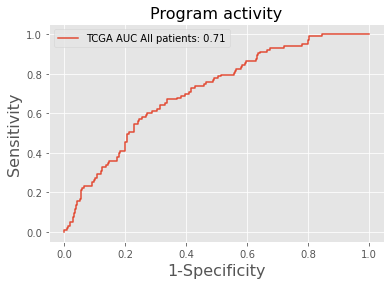

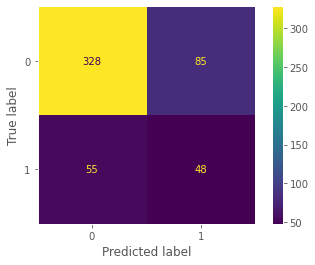

In [25]:
#Note: alpha_opt = 1 from 1000 iteration optimization
train_cut_high = 0.2
train_cut_low = 0.5
# Instantiate Ridge model using optimized parameters
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMmicroRNA.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)
high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_
X = np.array(feature_matrix.loc[:,pats_]).T
y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])
clf_all = Ridge(random_state=0,alpha=50,fit_intercept=True) #alpha_opt = 1
clf_all.fit(X, y) 
from sklearn import metrics
# Evaluate predictor on Training data using ROC AUC
pats_full = guanSurvivalDf.index
y = np.zeros(len(pats_full))
y[0:len(high_risk_)] = 1
decision_function_score_ = clf_all.predict(np.array(diff_matrix_.loc[:,pats_full]).T)
roc_ = roc_auc_score(y,decision_function_score_)
print("TCGA AUC: {:.2f}".format(roc_))
fpr_, tpr_, thresholds_ = metrics.roc_curve(y,decision_function_score_, pos_label=1)
print(fpr_)
print(tpr_)
# Plot prediction results
plt.figure()
plt.plot(fpr_,tpr_)
plt.ylabel("Sensitivity",FontSize=16)
plt.xlabel("1-Specificity",FontSize=16)
plt.title("Program activity",FontSize=16)
plt.legend(["TCGA AUC All patients: 0.71"])
#plt.savefig(os.path.join(resultsDirectory,"ROC_programswithallsigregulons_all_validations.pdf"),bbox_inches="tight")


TCGA AUC: 0.84


C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


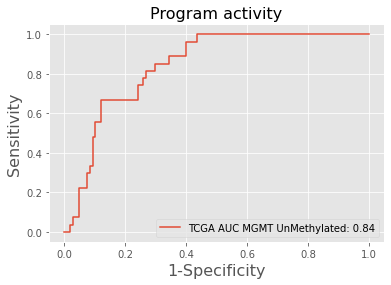

In [27]:
#Note: alpha_opt = 1 from 1000 iteration optimization
# Instantiate Ridge model using optimized parameters
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMmicroRNA.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBMUnMethylated.csv", header = 0, index_col = 0)

high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])
pats_full = guanSurvivalDf.index
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_
X = np.array(feature_matrix.loc[:,pats_]).T
y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])
clf_unmeth = Ridge(random_state=0,alpha=0,fit_intercept=True) #alpha_opt = 1
clf_unmeth.fit(X, y) 
from sklearn import metrics
# Evaluate predictor on Training data using ROC AUC
y = np.zeros(len(pats_full))
y[0:len(high_risk_)] = 1
decision_function_score_ = clf_unmeth.predict(np.array(diff_matrix_.loc[:,pats_full]).T)
roc_ = roc_auc_score(y,decision_function_score_)
print("TCGA AUC: {:.2f}".format(roc_))
fpr_, tpr_, thresholds_ = metrics.roc_curve(y,decision_function_score_, pos_label=1)

# Plot prediction results
plt.figure()
plt.plot(fpr_,tpr_)
plt.ylabel("Sensitivity",FontSize=16)
plt.xlabel("1-Specificity",FontSize=16)
plt.title("Program activity",FontSize=16)
plt.legend(["TCGA AUC MGMT UnMethylated: 0.84"])
#plt.savefig(os.path.join(resultsDirectory,"ROC_programswithallsigregulons_UnMethylated.pdf"),bbox_inches="tight")

TCGA AUC: 0.88


C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


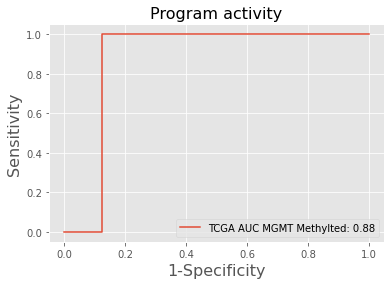

In [29]:
#Note: alpha_opt = 1 from 1000 iteration optimization
# Instantiate Ridge model using optimized parameters
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMmicroRNA.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBMMethylated.csv", header = 0, index_col = 0)

high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])
pats_full = guanSurvivalDf.index
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_ 
X = np.array(feature_matrix.loc[:,pats_]).T
y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])
clf = Ridge(random_state=0,alpha=0,fit_intercept=True) #alpha_opt = 1
clf.fit(X, y) 
from sklearn import metrics
# Evaluate predictor on Training data using ROC AUC
y = np.zeros(len(pats_full))
y[0:len(high_risk_)] = 1
decision_function_score_ = clf.predict(np.array(diff_matrix_.loc[:,pats_full]).T)
roc_ = roc_auc_score(y,decision_function_score_)
print("TCGA AUC: {:.2f}".format(roc_))
fpr_, tpr_, thresholds_ = metrics.roc_curve(y,decision_function_score_, pos_label=1)
from sklearn.model_selection import StratifiedKFold
#X = np.array(diff_matrix_.loc[:,pats_full]).T
#y = np.zeros(len(pats_full))
#y[0:len(high_risk_)] = 1
#skf = StratifiedKFold(n_splits=5)
#print(skf)
#StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
#for train_index, test_index in skf.split(X, y):
#    decision_function_score_ = clf.predict(X[test_index])
#    roc_ = roc_auc_score(y[test_index],decision_function_score_)
#    print("TCGA AUC: {:.2f}".format(roc_))
#    fpr_, tpr_, thresholds_ = metrics.roc_curve(y[test_index],decision_function_score_, pos_label=1)
#    plt.figure()
#    plt.plot(fpr_,tpr_)  
# Plot prediction results
plt.figure()
plt.plot(fpr_,tpr_) 
plt.ylabel("Sensitivity",FontSize=16)
plt.xlabel("1-Specificity",FontSize=16)
plt.title("Program activity",FontSize=16)
plt.legend(["TCGA AUC MGMT Methylted: 0.88"])
#plt.savefig(os.path.join(resultsDirectory,"ROC_programswithallsigregulons_Methylated.pdf"),bbox_inches="tight")

# Independent datasets

Patient_ID
GSM187160.CEL    1815.876990
GSM187158.CEL    1415.897385
GSM187228.CEL     925.580181
GSM187163.CEL     858.359274
GSM187196.CEL     813.342558
                    ...     
GSM187215.CEL     744.296649
GSM187214.CEL     742.471647
GSM187216.CEL     708.404943
GSM187206.CEL     696.238263
GSM187208.CEL     472.371351
Name: duration, Length: 76, dtype: float64
Patient_ID
GSM187160.CEL    1
GSM187158.CEL    1
GSM187228.CEL    1
GSM187163.CEL    1
GSM187196.CEL    1
                ..
GSM187215.CEL    0
GSM187214.CEL    0
GSM187216.CEL    0
GSM187206.CEL    0
GSM187208.CEL    0
Name: observed, Length: 76, dtype: int64
GSE7696 AUC: 0.50


C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


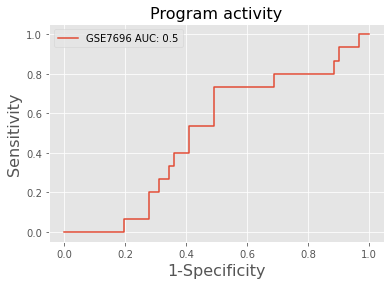

In [33]:
import os
input_path = os.getcwd()
#Note: alpha_opt = 1 from 1000 iteration optimization
# Instantiate Ridge model using optimized parameters
#Note: alpha_opt = 1 from 1000 iteration optimization
# Instantiate Ridge model using optimized parameters
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMGSE7696.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
# load primary survival data (i.e., corresponding to expression data training set)
survival = pd.read_csv(os.path.join(input_path,"GSE7696_Survival_Gbm.csv"),index_col=0,header=0)
survivalDf = survival.iloc[:,0:2]
#print(survivalDfMMRF)
survivalDf.columns = ["duration","observed"]
kmDf = miner.kmAnalysis(survivalDf=survivalDf,durationCol="duration",statusCol="observed")
guanSurvivalDf= miner.guanRank(kmSurvival=kmDf)
guanSurvivalDf.to_csv("guanSurvivalDf_GSE7696_GBM.csv")

guanSurvivalDf = pd.read_csv("guanSurvivalDf_GSE7696_GBM.csv", header = 0, index_col = 0)
high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_
X = np.array(feature_matrix.loc[:,pats_]).T
y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])
#clf = Ridge(random_state=0,alpha=alpha_opt_2,fit_intercept=True) #alpha_opt = 1
#clf.fit(X, y) 
from sklearn import metrics
# Evaluate predictor on Training data using ROC AUC
pats_full = guanSurvivalDf.index
y = np.zeros(len(pats_full))
y[0:len(high_risk_)] = 1
decision_function_score_ = clf_all.predict(np.array(diff_matrix_.loc[:,pats_full]).T)
roc_ = roc_auc_score(y,decision_function_score_)
print("GSE7696 AUC: {:.2f}".format(roc_))
fpr_GSE7696, tpr_GSE7696, thresholds_ = metrics.roc_curve(y,decision_function_score_, pos_label=1)

# Plot prediction results
plt.figure()
plt.plot(fpr_GSE7696,tpr_GSE7696)
plt.ylabel("Sensitivity",FontSize=16)
plt.xlabel("1-Specificity",FontSize=16)
plt.title("Program activity",FontSize=16)
plt.legend(["GSE7696 AUC: 0.5"])
#plt.savefig(os.path.join(resultsDirectory,"ROC_programswithallsigregulons_all_validationsGSE7696.pdf"),bbox_inches="tight")

Patient_ID
X466.CEL    629.017356
X514.CEL    569.400624
X055.CEL    531.988083
X416.CEL    481.192194
X009.CEL    354.962889
               ...    
X113.CEL    201.358554
X246.CEL    188.887707
X495.CEL    184.933536
X648.CEL    169.116852
X547.CEL    101.287611
Name: duration, Length: 234, dtype: float64
Patient_ID
X466.CEL    1
X514.CEL    1
X055.CEL    1
X416.CEL    1
X009.CEL    1
           ..
X113.CEL    0
X246.CEL    0
X495.CEL    0
X648.CEL    0
X547.CEL    0
Name: observed, Length: 234, dtype: int64
French AUC: 0.67


C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


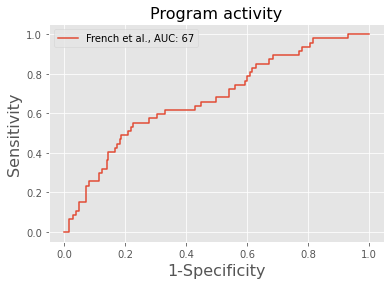

In [35]:
#Note: alpha_opt = 1 from 1000 iteration optimization
# Instantiate Ridge model using optimized parameters
#Note: alpha_opt = 1 from 1000 iteration optimization
# Instantiate Ridge model using optimized parameters
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMFrench.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
# load primary survival data (i.e., corresponding to expression data training set)
survival = pd.read_csv(os.path.join(input_path,"French_Survival_Gbm.csv"),index_col=0,header=0)
survivalDf = survival.iloc[:,0:2]
#print(survivalDfMMRF)
survivalDf.columns = ["duration","observed"]
kmDf = miner.kmAnalysis(survivalDf=survivalDf,durationCol="duration",statusCol="observed")
guanSurvivalDf= miner.guanRank(kmSurvival=kmDf)
guanSurvivalDf.to_csv("guanSurvivalDf_French.csv")

guanSurvivalDf = pd.read_csv("guanSurvivalDf_French.csv", header = 0, index_col = 0)
high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_
X = np.array(feature_matrix.loc[:,pats_]).T
y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])
#clf = Ridge(random_state=0,alpha=alpha_opt_2,fit_intercept=True) #alpha_opt = 1
#clf.fit(X, y) 
from sklearn import metrics
# Evaluate predictor on Training data using ROC AUC
pats_full = guanSurvivalDf.index
y = np.zeros(len(pats_full))
y[0:len(high_risk_)] = 1
decision_function_score_ = clf_all.predict(np.array(diff_matrix_.loc[:,pats_full]).T)
roc_ = roc_auc_score(y,decision_function_score_)
print("French AUC: {:.2f}".format(roc_))
fpr_french, tpr_french, thresholds_ = metrics.roc_curve(y,decision_function_score_, pos_label=1)

# Plot prediction results
plt.figure()
plt.plot(fpr_french,tpr_french)
plt.ylabel("Sensitivity",FontSize=16)
plt.xlabel("1-Specificity",FontSize=16)
plt.title("Program activity",FontSize=16)
plt.legend(["French et al., AUC: 67"])
#plt.savefig(os.path.join(resultsDirectory,"ROC_programswithallsigregulons_all_validationsFrench.pdf"),bbox_inches="tight")

Patient_ID
E09448.CEL     6873
HF1242.CEL     4470
E09893.CEL     3356
HF0990.CEL     2648
E09334.CEL     2557
               ... 
E10102.CEL     1164
E09855.CEL     1153
E09278.CEL     1097
X550715.CEL     961
E09782.CEL      520
Name: duration, Length: 224, dtype: int64
Patient_ID
E09448.CEL     1
HF1242.CEL     1
E09893.CEL     1
HF0990.CEL     1
E09334.CEL     1
              ..
E10102.CEL     0
E09855.CEL     0
E09278.CEL     0
X550715.CEL    0
E09782.CEL     0
Name: observed, Length: 224, dtype: int64
Rembrandt AUC: 0.58


C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


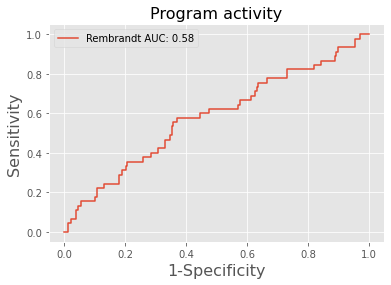

In [37]:
#Note: alpha_opt = 1 from 1000 iteration optimization
# Instantiate Ridge model using optimized parameters
#Note: alpha_opt = 1 from 1000 iteration optimization
# Instantiate Ridge model using optimized parameters
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMRembrandt.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
# load primary survival data (i.e., corresponding to expression data training set)
survival = pd.read_csv(os.path.join(input_path,"Rembrandt_Survival_Gbm.csv"),index_col=0,header=0)
survivalDf = survival.iloc[:,0:2]
#print(survivalDfMMRF)
survivalDf.columns = ["duration","observed"]
kmDf = miner.kmAnalysis(survivalDf=survivalDf,durationCol="duration",statusCol="observed")
guanSurvivalDf= miner.guanRank(kmSurvival=kmDf)
guanSurvivalDf.to_csv("guanSurvivalDf_Rembrandt_GBM.csv")

guanSurvivalDf = pd.read_csv("guanSurvivalDf_Rembrandt_GBM.csv", header = 0, index_col = 0)
high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_
X = np.array(feature_matrix.loc[:,pats_]).T
y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])
#clf = Ridge(random_state=0,alpha=alpha_opt_2,fit_intercept=True) #alpha_opt = 1
#clf.fit(X, y) 
from sklearn import metrics
# Evaluate predictor on Training data using ROC AUC
pats_full = guanSurvivalDf.index
y = np.zeros(len(pats_full))
y[0:len(high_risk_)] = 1
decision_function_score_ = clf_all.predict(np.array(diff_matrix_.loc[:,pats_full]).T)
roc_ = roc_auc_score(y,decision_function_score_)
print("Rembrandt AUC: {:.2f}".format(roc_))
fpr_rembrandt, tpr_rembrandt, thresholds_ = metrics.roc_curve(y,decision_function_score_, pos_label=1)

# Plot prediction results
plt.figure()
plt.plot(fpr_rembrandt,tpr_rembrandt)
plt.ylabel("Sensitivity",FontSize=16)
plt.xlabel("1-Specificity",FontSize=16)
plt.title("Program activity",FontSize=16)
plt.legend(["Rembrandt AUC: 0.58"])
#plt.savefig(os.path.join(resultsDirectory,"ROC_programswithallsigregulons_all_validationsRembrandt.pdf"),bbox_inches="tight")

# Confusion matrix example script

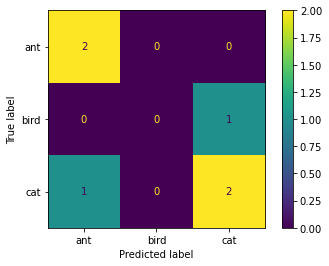

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
cm = confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
labels=["ant", "bird", "cat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

disp = disp.plot(include_values=True,
                 cmap='viridis', ax=None, xticks_rotation='horizontal')

# Example script: Survival plot from coxnet results

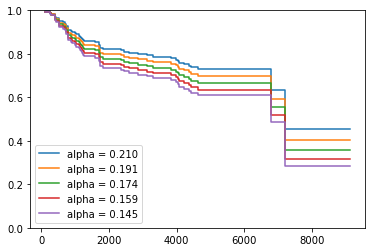

In [41]:
import matplotlib.pyplot as plt
from sksurv.datasets import load_breast_cancer
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
X, y = load_breast_cancer()
X = OneHotEncoder().fit_transform(X)
estimator = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
estimator.fit(X, y)
chf_funcs = {}
for alpha in estimator.alphas_[:5]:
    chf_funcs[alpha] = estimator.predict_survival_function(
        X.iloc[:1], alpha=alpha)
for alpha, chf_alpha in chf_funcs.items():
    for fn in chf_alpha:
        plt.step(fn.x, fn(fn.x), where="post",
                 label="alpha = {:.3f}".format(alpha))

plt.ylim(0, 1)
plt.legend()
plt.show()

# Cox net hyper-parameter tuning

In [217]:
from sksurv.datasets import load_breast_cancer
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold

dfr_programs = pd.read_csv("guanSurvivalDf_TCGA_GBMWithAtleast20PercActiveProgramsWithAllRegulons.csv", header = 0, index_col = 0)
# =============================================================================
# Ridge regression to predict risk from regulon activity
# =============================================================================

# Training and test set risk cut-offs
#train_cut_high = 0.50
#train_cut_low = 0.50
#test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
#diff_matrix_ = dfr_programs
#guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)

#high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
#low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
#pats_ = np.hstack([high_risk_,low_risk_])
#print('High-risk MMRF: {:d} samples\nLow-risk MMRF: {:d} samples'.format(
#        len(high_risk_),len(low_risk_)))
#feature_matrix = diff_matrix_
#survival_matrix = guanSurvivalDf
#pats_all = guanSurvivalDf.index
#X = feature_matrix.loc[:,pats_all].
#print(X)
#y = survival_matrix
#print(y)
#y['observed'] = np.where(y['observed']== 1, True, False)
#y['duration'] = y['duration'].astype(float)
#y = y[['observed','duration']]
#y['duration'] = y['duration'].astype(float)
#y = y.loc[pats_all,:]
#y = [tuple(x) for x in y.values]
#dt=np.dtype({'names':['observed','duration'], 'formats':['bool', 'f8']})
#y = np.array(y, dtype = dt)

#Xt = OneHotEncoder().fit_transform(X)

TrainingDataTCGA = pd.read_csv("guanSurvivalDf_TCGA_GBMWithProgramActivityAllProgramsWithAllRegulons.csv", header = 0)
TrainingDataTCGA['D_PFS_FLAG'] = np.where(TrainingDataTCGA['D_PFS_FLAG']== 1, True, False)
TrainingDataTCGA['D_PFS'] = TrainingDataTCGA['D_PFS'].astype(float)
subset = TrainingDataTCGA[['D_PFS_FLAG', 'D_PFS']]
subset['D_PFS'] = subset['D_PFS'].astype(float)
y = [tuple(x) for x in subset.values]
dt=np.dtype({'names':['cens','time'], 'formats':['bool', 'f8']})
ytrain = np.array(y, dtype=dt)
X = TrainingDataTCGA.drop("Patient_ID", axis=1)
X = X.drop("D_PFS_FLAG", axis=1)
X = X.drop("D_PFS", axis=1)
#X = X.drop("Subtype", axis=1)
#X = X.drop("MGMT_status", axis=1)
#X = X.drop("IDH1Status", axis=1)
Xtrain = OneHotEncoder().fit_transform(X)
#Xt = np.column_stack(Xt.values)

feature_names = X.columns.tolist()

cv = KFold(n_splits=5, shuffle=True, random_state=328)
coxnet = CoxnetSurvivalAnalysis(n_alphas = 100000, alpha_min_ratio = 0.01).fit(Xtrain, ytrain)

gcv = GridSearchCV(coxnet,
    {"alphas": [[v] for v in coxnet.alphas_], "l1_ratio": np.arange(0, 1, 0.001)}, cv = cv).fit(Xtrain, ytrain)
print('C-index: %.3f' % gcv.best_score_)
print('Config: %s' % gcv.best_params_)

C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kkavy\anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py", line 233, in fit
    create_path, alphas, penalty, alpha_min_ratio = self._check_params(*X.shape)
  File "C:\Users\kkavy\anaconda3\lib\site

C-index: 0.572
Config: {'alphas': [0.22114519594087367], 'l1_ratio': 0.035}


In [219]:
from sksurv.datasets import load_breast_cancer
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold

dfr_programs = pd.read_csv("program_activity_forAllRegulonsinAllProgramsGbmTCGA.csv", header = 0, index_col = 0)
# =============================================================================
# Ridge regression to predict risk from regulon activity
# =============================================================================

# Training and test set risk cut-offs
#train_cut_high = 0.50
#train_cut_low = 0.50
#test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
#diff_matrix_ = dfr_programs
#guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)

#high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
#low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
#pats_ = np.hstack([high_risk_,low_risk_])
#print('High-risk MMRF: {:d} samples\nLow-risk MMRF: {:d} samples'.format(
#        len(high_risk_),len(low_risk_)))
#feature_matrix = diff_matrix_
#survival_matrix = guanSurvivalDf
#pats_all = guanSurvivalDf.index
#X = feature_matrix.loc[:,pats_all].
#print(X)
#y = survival_matrix
#print(y)
#y['observed'] = np.where(y['observed']== 1, True, False)
#y['duration'] = y['duration'].astype(float)
#y = y[['observed','duration']]
#y['duration'] = y['duration'].astype(float)
#y = y.loc[pats_all,:]
#y = [tuple(x) for x in y.values]
#dt=np.dtype({'names':['observed','duration'], 'formats':['bool', 'f8']})
#y = np.array(y, dtype = dt)

#Xt = OneHotEncoder().fit_transform(X)

TrainingDataTCGA = pd.read_csv("guanSurvivalDf_TCGA_GBMWithProgramActivityAllProgramsWithAllRegulons.csv", header = 0)
TrainingDataTCGA['D_PFS_FLAG'] = np.where(TrainingDataTCGA['D_PFS_FLAG']== 1, True, False)
TrainingDataTCGA['D_PFS'] = TrainingDataTCGA['D_PFS'].astype(float)
subset = TrainingDataTCGA[['D_PFS_FLAG', 'D_PFS']]
subset['D_PFS'] = subset['D_PFS'].astype(float)
y = [tuple(x) for x in subset.values]
dt=np.dtype({'names':['cens','time'], 'formats':['bool', 'f8']})
y = np.array(y, dtype=dt)
X = TrainingDataTCGA.drop("Patient_ID", axis=1)
X = X.drop("D_PFS_FLAG", axis=1)
X = X.drop("D_PFS", axis=1)
#X = X.drop("Subtype", axis=1)
#X = X.drop("MGMT_status", axis=1)
#X = X.drop("IDH1Status", axis=1)
Xt = OneHotEncoder().fit_transform(X)
#Xt = np.column_stack(Xt.values)

feature_names = X.columns.tolist()

coxnet = CoxnetSurvivalAnalysis(alphas = (0.22114519594087367, 0.02), l1_ratio = 0.035, alpha_min_ratio = 0.01).fit(Xtrain, ytrain)
print(coxnet.score(Xt,y))

0.724500657441613


C:\Users\kkavy\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
from sksurv.datasets import load_breast_cancer
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold

dfr_programs = pd.read_csv("program_activity_forAllRegulonsinAllProgramsGbmTCGA.csv", header = 0, index_col = 0)
# =============================================================================
# Ridge regression to predict risk from regulon activity
# =============================================================================

# Training and test set risk cut-offs
#train_cut_high = 0.50
#train_cut_low = 0.50
#test_cut = 0.20
# Optimize predictor parameters
# Split MMRF training
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)

#high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
#low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
#pats_ = np.hstack([high_risk_,low_risk_])
#print('High-risk MMRF: {:d} samples\nLow-risk MMRF: {:d} samples'.format(
#        len(high_risk_),len(low_risk_)))
feature_matrix = diff_matrix_
survival_matrix = guanSurvivalDf
pats_all = guanSurvivalDf.index
X = feature_matrix.loc[:,pats_all].T
y = survival_matrix.loc[pats_all,:]
y['observed'] = np.where(y['observed']== 1, True, False)
y['duration'] = y['duration'].astype(float)
y = y[['observed', 'duration']]
y['duration'] = y['duration'].astype(float)
y = [tuple(x) for x in y.values]
dt=np.dtype({'names':['cens','time'], 'formats':['bool', 'f8']})
y = np.array(y, dtype=dt)

Xt = OneHotEncoder().fit_transform(X)
X, y = load_breast_cancer()
X = OneHotEncoder().fit_transform(X)
estimator = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
estimator.fit(X, y)

CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.99)

In [8]:
import os
os.chdir('E:\ISB work stuff\Post-Doc_BaligaLab_GBMSYGNALProject')
from numpy import arange
import pandas as pd
from pandas import read_csv
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
# load the dataset
from sksurv.datasets import load_breast_cancer
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold

# =============================================================================
dfr_programs = pd.read_csv("program_activity_forSigRegulonsMinerGBMmicroRNA.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)
train_cut_high = 0.2
train_cut_low = 0.5
high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_
X = np.array(feature_matrix.loc[:,pats_]).T
y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# define model
ratios = arange(0.01, 1, 0.01)
#alphas = arange(0, 5000, 50)
model = ElasticNetCV(l1_ratio=ratios, cv=cv, n_jobs=-1)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)
print(model.score(X, y))

C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


alpha: 13.851795
l1_ratio_: 0.990000
0.11828292584639488


In [19]:
import os
os.chdir('E:\ISB work stuff\Post-Doc_BaligaLab_GBMSYGNALProject')
from numpy import arange
import pandas as pd
from pandas import read_csv
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
# load the dataset
from sksurv.datasets import load_breast_cancer
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

# =============================================================================
#TrainingDataTCGA = pd.read_csv("guanSurvivalDf_TCGAmod0.2HighRisk0.5BelowLowRisk_GBMWithProgramActivityAllProgramsWithAllRegulons.csv", header = 0)
#y = TrainingDataTCGA[['D_PFS']]
#X = TrainingDataTCGA.drop("Patient_ID", axis=1)
#X = X.drop("D_PFS_FLAG", axis=1)
#X = X.drop("D_PFS", axis=1)

dfr_programs = pd.read_csv("program_activity_forAllRegulonsinAllProgramsGbmTCGA.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)
train_cut_high = 0.2
train_cut_low = 0.5
high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*train_cut_high)]
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*train_cut_low):]
pats_ = np.hstack([high_risk_,low_risk_])

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_
X = np.array(feature_matrix.loc[:,pats_]).T
y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: 0.031
Config: {'alpha': 0.1, 'l1_ratio': 0.09}


In [90]:
import os
os.chdir('E:\ISB work stuff\Post-Doc_BaligaLab_GBMSYGNALProject')
from numpy import arange
import pandas as pd
from pandas import read_csv
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
# load the dataset
from sksurv.datasets import load_breast_cancer
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

# =============================================================================
#TrainingDataTCGA = pd.read_csv("guanSurvivalDf_TCGAmod0.2HighRisk0.5BelowLowRisk_GBMWithProgramActivityAllProgramsWithAllRegulons.csv", header = 0)
#y = TrainingDataTCGA[['D_PFS']]
#X = TrainingDataTCGA.drop("Patient_ID", axis=1)
#X = X.drop("D_PFS_FLAG", axis=1)
#X = X.drop("D_PFS", axis=1)

dfr_programs = pd.read_csv("program_activity_forAllRegulonsinAllProgramsGbmTCGA.csv", header = 0, index_col = 0)
diff_matrix_ = dfr_programs
guanSurvivalDf = pd.read_csv("guanSurvivalDf_TCGA_GBM.csv", header = 0, index_col = 0)
train_cut_high = 0.2
train_cut_low = 0.5
guanSurvivalDf['Risk'] = np.where(guanSurvivalDf['duration']< 400, 1, 0)
#high_risk_ = guanSurvivalDf[guanSurvivalDf['Risk'] == 1].index
high_risk_ = guanSurvivalDf.index[0:round(guanSurvivalDf.shape[0]*0.6)]
#low_risk_ = guanSurvivalDf[guanSurvivalDf['Risk'] == 0].index
low_risk_= guanSurvivalDf.index[round(guanSurvivalDf.shape[0]*0.2):]
pats_ = np.hstack([high_risk_,low_risk_])

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
feature_matrix = diff_matrix_
X = np.array(feature_matrix.loc[:,pats_]).T
#y = np.array(guanSurvivalDf.loc[pats_,"GuanScore"])
#y = guanSurvivalDf[['Risk']]
y = np.zeros(len(pats_))
y[0:len(high_risk_)] = 1
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
#model = ElasticNet()
model = SGDClassifier(max_iter=1000, tol=1e-3, loss = 'log', penalty = 'elasticnet')
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0,1,0.01)
# define search
search = GridSearchCV(model, grid, cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
# define model evaluation method
#cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# define model
#ratios = arange(0.01, 1, 0.01)
#alphas = arange(0, 5000, 50)
#model = ElasticNetCV(alphas = alphas, l1_ratio=ratios, cv=cv, n_jobs=-1)
# fit model
#model.fit(X, y)
# summarize chosen configuration
#print('alpha: %f' % model.alpha_)
#print('l1_ratio_: %f' % model.l1_ratio_)
#print(model.score(X, y))

Accuracy: 0.571
Config: {'alpha': 0.1, 'l1_ratio': 0.1}


0.3992248062015504
[[0.5573766  0.4426234 ]
 [0.5607197  0.4392803 ]
 [0.57505214 0.42494786]
 ...
 [0.58811219 0.41188781]
 [0.59139333 0.40860667]
 [0.55087333 0.44912667]]
Logistic: ROC AUC=0.626


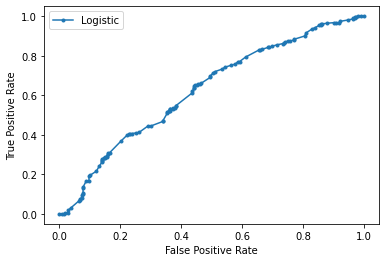

In [92]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
model = SGDClassifier(max_iter=1000, tol=1e-3, alpha=0.1, l1_ratio=0.1, loss = 'log', penalty = 'elasticnet')
model = model.fit(X,y)
pats_all = guanSurvivalDf.index
Xall = np.array(feature_matrix.loc[:,pats_all]).T
yall = np.zeros(len(pats_all))
yall[0:len(high_risk_)] = 1
print(model.score(Xall, yall))
print(model.predict_proba(Xall))
lr_probs = model.predict_proba(Xall)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(yall, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(yall, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
#fpr, tpr, thresholds = metrics.roc_curve(yall, model.predict(Xall), pos_label=3)
#metrics.auc(fpr, tpr)

In [62]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
cv = StratifiedKFold(n_splits=5, random_state = 0)
clf = SGDClassifier(max_iter=1000, tol=1e-3, alpha=0.1, l1_ratio=0.04, loss = 'log', penalty = 'elasticnet')
y = pd.DataFrame({'Risk': y[:, 0]})
clf.fit(X = X, y = y)
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X,y):
    prediction = clf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f ) for 5-fold cross validation' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for all TCGA samples', fontsize=18)
plt.legend(loc="lower right")
#plt.text(0.32,0.7,'More accurate area',fontsize = 12)
#plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

C:\Users\kkavy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


IndexError: too many indices for array

In [65]:
y = pd.DataFrame(y)

In [91]:
len(lr_fpr)

148